<a href="https://colab.research.google.com/github/vanislekahuna/Statistical-Rethinking-PyMC/blob/main/Chp_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statistical Rethinking: A Bayesian Course with Examples in Python**

# **Chapter 7 - Ulysses' Compass**

## Key Takeaway

Jump to [Section 7.6](#scrollTo=8I54OYFW36yX)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b4/Head_Odysseus_MAR_Sperlonga.jpg/960px-Head_Odysseus_MAR_Sperlonga.jpg" width=609 height=720>

[Source](https://en.wikipedia.org/wiki/Odysseus)

## **Intro**

We start with the famous story of Mikołaj Kopernik (Copernicus), who argued for a **heliocentric (Sun-centered)** model to replace the old geocentric (Earth-centered) model. This is often framed as science triumphing over ideology, but Kopernik’s original justification was surprisingly weak. *His model was neither more accurate nor particularly harmonious* because he still assumed perfect circular orbits and his model required complex extra circles, called epicycles, just like the old Ptolemaic model. In fact, his model made exactly the same predictions as the old one.

However, Kopernik did appeal to a different principle: *simplicity*. He argued his model was superior because it achieved the same result using fewer causes and required fewer epicycles than its competitor. This preference for simpler theories often relies on **Ockham's Razor** which is a principle stating that models with fewer assumptions should be preferred. In the case of Kopernik and Ptolemy, Ockham's razor offered a clear resolution since their predictions were identical.

The difficulty is that, usually, we have to choose among models that differ in both **accuracy** and **simplicity**. Ockham's razor doesn't tell us how to trade those criteria off against one another.

Instead of Ockham's razor, we should think of **Ulysses' compass** to navigate this trade-off. We must navigate between two fundamental types of statistical error:

- **Overfitting**: Like the many-headed beast, Scylla, this monster leads to poor prediction because the model learns too much from the specific quirks of the data.

- **Underfitting**: Like the whirpool sea monster, Charybdis, who pulled boats and men to their watery grave, underfitting leads to poor prediction because the model learns too little from the data.

There is also a third issue: **confounding**. A confounded model that incorrectly measures causes can *sometimes produce better predictions than a model that correctly measures a causal relationship*.

> Since different models are needed for each task, this forces us to decide whether our goal is to *understand causes* or merely to *make predictions*.

No matter the goal, we must deal with the overfitting and underfitting monsters. There are two main ways to carefully navigate this challenge:

1. Using a **regularizing prior** (also known as **penalized likelihood**) which "dumbs down the model" to prevent it from getting overexcited by the data. There's usually two penalties we can pick from:

    * The **L1 Penalty** which is similar to feature selection which will reduce certain features down to 0;
    * The **L2 Penalty** which lowers the value of all the features uniformly.

2. Using a scoring device like **information criteria** or **cross-validation** to explicitly estimate a model's predictive accuracy.

Both approaches are commonly used and should often be used in combination. To introduce **information criteria** (like AIC, DIC, WAIC, and PSIS-LOO), we first have to cover information theory, which might seem strange at first. The irony is that while using these criteria is easy, truly understanding their conceptual foundations is much harder and normally takes more time to comprehend.

#### Figure 7.1. Solar system model comparison.

<img src="https://raw.githubusercontent.com/vanislekahuna/Statistical-Rethinking-PyMC/refs/heads/main/Bayes-Textbook-Images/Fig7.1_Solar_System_Model_Comparison.png" width=543 height=401>

[Source](https://speakerdeck.com/rmcelreath/statistical-rethinking-fall-2017-lecture-07?slide=3)

### **Rethinking: Stargazing.**

The most common way many scientists currently choose a model is by searching for one where every predictor's coefficient is **statistically significant**. This practice, sometimes called "stargazing" because it involves looking for asterisks (**) next to estimates, assumes the model full of stars is the best.

However, this method is fundamentally flawed. Regardless of your general opinion on null hypothesis significance testing, using p-values to select between models with different structures is a mistake. P-values are not designed to help you navigate the crucial trade-off between underfitting and overfitting. You will find that predictor variables which significantly improve a model's predictive power are not always statistically significant. Conversely, a variable might be statistically significant but offer no useful contribution to prediction. Since the conventional 5% significance threshold is arbitrary, it cannot be expected to optimize the balance between simplicity and accuracy.

### **Rethinking: IS AIC Bayesian?**


In [ ]:
%%capture
!pip install arviz==0.22.0
!pip install matplotlib==3.10.0
!pip install numpy==2.0.2
!pip install pandas==2.2.2
!pip install pymc==5.26.1
!pip install scipy==1.16.2

# !pip install networkx==3.5
# !pip install seaborn==0.13.2

In [ ]:
import logging
import math

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tqdm

# from aesara import shared
from patsy import dmatrix
from scipy import stats
from scipy.special import logsumexp

In [ ]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
np.random.seed(0)

/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:345: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


## ***Section 7.1* - The problem with parameters.**

In previous chapters, we learned that adding variables can both help (by revealing hidden effects) and hurt (by causing collider bias when the causal model is flawed). However, what if we want to abandon the goal of causal inference because our interest was only on predictive accuracy? In the grandparent-parent-child example, simply adding all variables improved the model's predictive accuracy, regardless of whether we understand the underlying causes. The question then becomes: is "just adding everything" ever okay? The answer is no, due to two related problems.

The first problem is that adding more parameters, thus making the model more complex, almost always improves the model's fit to the sample data used to train it. Measures like $R^2$, which are designed to quantify that amount of variance that a model can explain, increases as you add more predictor variables, even if they were just random noise. Therefore, choosing a model based solely on how well it fits the existing data is unreliable. $R^2$ is calculated using the following formula:

$$ R^2 = \frac{SS_\text{Resid} = \sum_{i=1}^{n} (y - \hat{y})^2}{SS_\text{Total} = \sum_{i=1}^{n} (y - \bar{y})^2}$$

Second, while complex models fit the existing data well, they often make worse predictions on new data. Models with many parameters tend to **overfit**, meaning they become too sensitive to the specific training sample and make large errors on future data. On the other hand, simple models with too few parameters tend to **underfit**, systematically mispredicting the outcome regardless of how closely future data resembles the past. Since we can't always favor the simplest or the most complex model, we must seek a balance between them.

Let's now examine these issues with a simple example.

### 7.1.1. More parameters (almost) always improves fit.

**Overfitting** happens when a statistical model learns too much from the specific characteristics of the sample data. Every sample contains both <u>**regular features**</u> which generalize well and are the target of our learning and <u>**irregular features**</u> which do not generalize and can mislead us.

Unfortunately, overfitting occurs automatically in the types of models we've seen so far because adding more parameters usually improves the fit of the model to the sample data. The core issue is that the model mistakes the irregular, non-generalizable features for useful patterns. To illustrate this concept, we'll look at an example using data on the average brain volumes and body masses of seven hominin species.

#### Code 7.1

In [ ]:
brains = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

brains

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


### Figure 7.2. A scatterplot of average brain volume and body mass of hominin species.

Text(1.32, 0.75, 'Figure 7.2. Average brain volume in cubic \n     centimetres against body mass in kilograms, \n     for six hominin species. What model best \n     describes the relationship between brain size \n     and body size?')

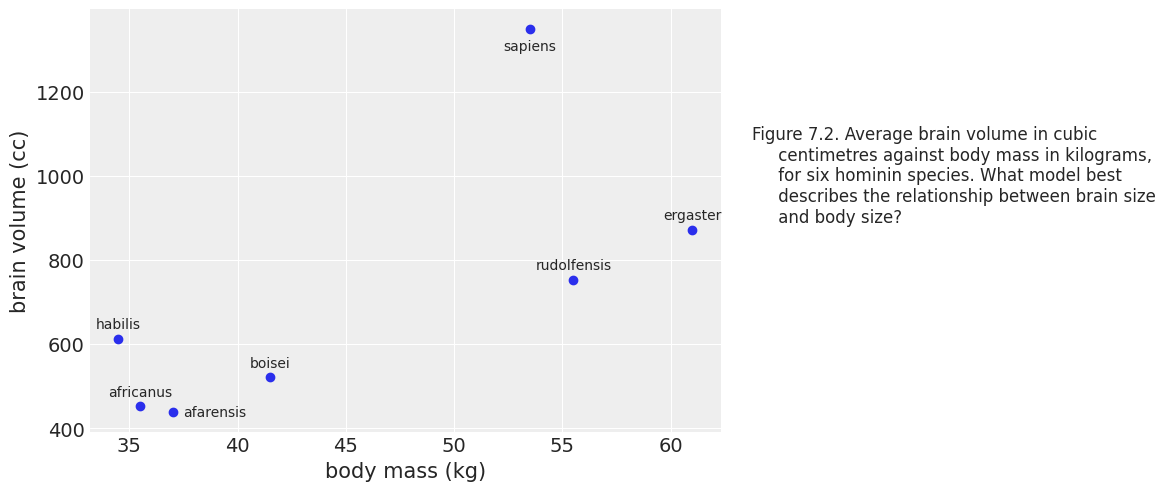

In [ ]:
plt.scatter(brains.mass, brains.brain)

# point labels
for i, r in brains.iterrows():
    if r.species == "afarensis":
        plt.text(r.mass + 0.5, r.brain, r.species, ha="left", va="center")
    elif r.species == "sapiens":
        plt.text(r.mass, r.brain - 25, r.species, ha="center", va="top")
    else:
        plt.text(r.mass, r.brain + 25, r.species, ha="center")

plt.xlabel("body mass (kg)")
plt.ylabel("brain volume (cc)")

#####################
### CODE ADDITION ###
#####################
plt.suptitle(
    x=1.32,
    y=.75,
    t="Figure 7.2. Average brain volume in cubic \n \
    centimetres against body mass in kilograms, \n \
    for six hominin species. What model best \n \
    describes the relationship between brain size \n \
    and body size?",
    ma="left"
  )

After organizing the hominin brain and body size data, the goal is to understand which species have brains larger than expected after accounting for body size. The standard approach is to use a statistical control strategy by fitting a linear regression to model brain size as a function of body size. The remaining variation can then be explained by other factors like diet or ecology.

However, the assumption that the relationship between body size and brain size must be a straight line is not scientifically certain... Functions such as a curved relationship, a parabolic, a cubic, or even quintic function are all certainly within the realms of possibility.

Let's explore this idea by fitting a series of increasingly complex polynomial regression models to the data. Note that polynomial regressions are generally a *bad idea and can be particularly misleading when used without theoretical justification*.

Before fitting the models, we will rescale the variables. We will standardize the predictor, body mass, by giving it a mean of $0$ and a standard deviation of $1$. We will rescale the target variable, brain volume, so that the largest observed value is $1$. We choose not to standardize brain volume to preserve the conceptual reference point of zero, as a brain volume cannot be negative. The simplest model, the linear one, will be our starting point.

#### Code 7.2

In [ ]:
brains.loc[:, "mass_std"] = (brains.loc[:, "mass"] - brains.loc[:, "mass"].mean()) / brains.loc[:, "mass"].std()
brains.loc[:, "brain_std"] = brains.loc[:, "brain"] / brains.loc[:, "brain"].max()

#### Code 7.3

This is modified from [Chapter 6 of 1st Edition](https://nbviewer.org/github/pymc-devs/pymc-resources/blob/main/Rethinking/Chp_06.ipynb) (6.2 - 6.6).

Here's the first linear model we'll fit on the data simply says that the average brain volume $b_i$ of species $i$ is a linear function of its body
mass $m_i$. Now consider what the priors imply. The prior for $\alpha$ is just centered on the mean brain volume (rescaled) in the data so it says that the average species with an average body mass has a brain volume with an 89% credible interval from about −1 to 2. This is ridiculously wide and includes impossible (negative) values! Additionally, the prior for $\beta$ is very flat and centered on zero which allows for absurdly large positive and negative relationships. These priors allow for absurd inferences, especially as the model gets more complex which is part of the lesson we're trying to drive home:

$ b_i \sim \text{Normal}(\mu_i, \sigma) $

$ \mu_i = \alpha + \beta m_i $

$ \alpha \sim \text{Normal}(0.5, 1) $

$ \beta \sim \text{Normal}(0, 10) $

$ \sigma \sim \text{Log-Normal}(0, 1) $

In [ ]:
m_7_1 = smf.ols("brain_std ~ mass_std", data=brains).fit()
m_7_1.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Sat, 10 Jan 2026   Prob (F-statistic):             0.0798
Time:                        04:06:53   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1671      0.076      2.192      0.080      -0.029       0.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### **Rethinking: OLS and Bayesian anti-essentialism**

It's possible to use the standard non-Bayesian method of **Ordinary Least Squares (OLS)**, also known as a standard (non-Bayesian) simple linear regression model, to get the results for these brain size models. While OLS won't give you a posterior for the uncertainty ($\sigma$), as long as we use vague priors, the OLS procedure, which minimizes the distance between the data points and the regression line, is equivalent to finding the posterior mean in a Bayesian model. Interestingly, Carl Friedrich Gauss actually derived OLS using a Bayesian framework originally. The main takeaway is that nearly every non-Bayesian statistical method has an approximate Bayesian interpretation. This fact is powerful because understanding a non-Bayesian method in terms of its Bayesian assumptions can help you understand why it works. Conversely, a complex Bayesian model can often be run more quickly using a simpler, approximate non-Bayesian method. Ultimately, Bayesian inference just means finding the posterior distribution; it doesn't specify which particular mathematical tool you must use to find it.

#### Code 7.4

In [ ]:
p, cov = np.polyfit(brains.loc[:, "mass_std"], brains.loc[:, "brain_std"], 1, cov=True)

post = stats.multivariate_normal(p, cov).rvs(1000)

az.summary({k: v for k, v in zip("ba", post.T)}, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.528,0.069,0.410,0.634
b,0.169,0.074,0.058,0.294


#### Code 7.5

The goal of this discussion isn't to praise the $R^2$ measure, but to show its limitations before we move on to better tools. To calculate $R^2$, which measures how well our model fits the data we used to build it, we first need to figure out the model's predictions for each data point. We then subtract the actual observation from its prediction to get the residual. Next, we need to calculate the variance for both the residuals and the original outcome variable. Here's a [recap](#scrollTo=zLNCKKKefq7f) of the actual $R^2$ formula that we provided earlier. I caution you to use the exact *empirical variance*, which is the average squared deviation from the mean, instead of the standard function, which uses a frequentist estimator. Although a fully Bayesian approach would technically require calculating this for every sample from the posterior, we'll follow tradition here and just compute $R^2$ using the average (mean) prediction:



In [ ]:
1 - m_7_1.resid.var() / brains.brain_std.var()

0.490158047949084

#### Code 7.6

Then let's encode this manual process into a function called `R2_is_bad()` for future use:

In [ ]:
def R2_is_bad(model):
  """
    Calculates the R-squared (R2) value for a fitted regression model,
    using the definition based on the variance of residuals and the
    variance of the outcome variable.

    Note: This function assumes that 'model.resid' and 'brains.brain_std'
    are pandas Series or NumPy arrays with a '.var()' method returning
    the *sample* variance (N-1 denominator). If the intention is to use
    the empirical variance (N denominator) as discussed in the text,
    the .var() method may need adjustment or replacement with a custom
    variance calculation (e.g., using a custom 'var2' function).

    The R2 value calculated here is the standard measure of fit to the
    sample data, which tends to be optimistically high for complex models.

    Args:
        model (statsmodels.regression.linear_model.RegressionResultsWrapper):
            A fitted regression model object, typically returned by
            `smf.ols(...).fit()`. It must possess a '.resid' attribute
            containing the model residuals.

    Returns:
        float: The R-squared value, calculated as:
               1 - (Variance of Residuals / Variance of Outcome Variable)
  """
  return 1 - model.resid.var() / brains.brain_std.var()


R2_is_bad(m_7_1)

0.490158047949084

#### Code 7.7

Now let's add five more models to compare their predictive accuracy against one another. Each of these models will be more complex than the last as we will be adding a polynomial of a higher degree to each one. For example, a 2nd degree polynomial relating body size to brain size will be a **parabola** with $\beta$ defined a a vector which we'll notate as:

$ b_i \sim \text{Normal}(\mu_i, \sigma) $

$ \mu_i = \alpha + \beta_1 m_i + \beta_2 m_i^2$

$ \alpha \sim \text{Normal}(0.5, 1) $

$ \beta_j \sim \text{Normal}(0, 10) \text{ for } j = 1..2  $

$ \sigma \sim \text{Log-Normal}(0, 1) $

Note that in the line for $B_j$ where it says $\text{for } j = 1..2$, this notation is a mathematically concise way for saying "for $j$ equals 1 and 2." and IS NOT A TYPO. This convention is referring to the beta parameters in the $\mu_i$ equation where the prior of $\beta_j \sim \text{Normal}(0, 10)$ applies separately to both $\beta_1$ <u>and</u> $\beta_2$.

In [ ]:
m_7_2 = smf.ols("brain_std ~ mass_std + I(mass_std**2)", data=brains).fit()
m_7_2.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     2.310
Date:                Sat, 10 Jan 2026   Prob (F-statistic):              0.215
Time:                        04:06:54   Log-Likelihood:                 3.3223
No. Observations:                   7   AIC:                           -0.6445
Df Residuals:                       4   BIC:                           -0.8068
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6142      0.155      3.950      0.017       0.182       1.046
mass_std             0.1957      0.093      2.101      0.104      -0.063       0.454
I(mass_std ** 2)    -0.0998      0.159     -0.629      0.564      -0.540       0.341
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.479
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.016
Skew:                           0.901   Prob(JB):                        0.602
Kurtosis:                       2.514   Cond. No.                         4.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Code 7.8

And below, we'll be constructing four more models (i.e. models `m_7_3` through to `m_7_6`) in a similar way by adding a third, fourth, fifth, and sixth-degree polynomial to each one respectively:

In [ ]:
m_7_3 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)", data=brains).fit()
m_7_4 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)",
    data=brains,
).fit()
m_7_5 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5)",
    data=brains,
).fit()

#### Code 7.9

Note that our last model, `m_7_6` has a slight adjustment where we'll be replacing the standard deviation with a constant value of $0.001$ because the model will not work otherwise. The reason for this will be clear as we plot them in [Figure 7.3](#scrollTo=_9m79q6PCp0A).

In [ ]:
m_7_6 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5) + I(mass_std**6)",
    data=brains,
).fit()

### Figure 7.3. Polynomial linear models of increasing degree for the hominin data.

#### Code 7.10

The chapter gives code to produce the first panel of Figure 7.3. Here, produce the entire figure by looping over models 7.1-7.6.

To sample the posterior predictive on a new independent variable we make use of theano SharedVariable objects, as outlined [here](https://docs.pymc.io/notebooks/data_container.html)

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


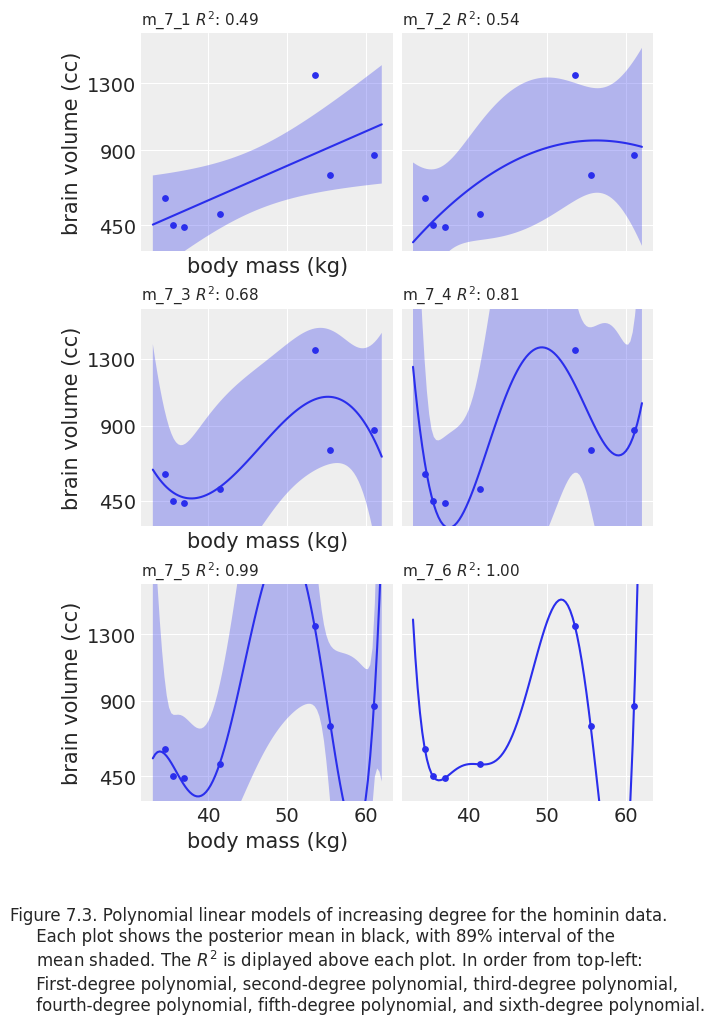

In [ ]:
models = [m_7_1, m_7_2, m_7_3, m_7_4, m_7_5, m_7_6]
names = ["m_7_1", "m_7_2", "m_7_3", "m_7_4", "m_7_5", "m_7_6"]

mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - brains.mass.mean()) / brains.mass.std()

fig, axs = plt.subplots(3, 2, figsize=[6, 8.5], sharex=True, sharey="row")

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha=0.11) * brains.brain.max()

    ax.plot(mass_plot, pred["mean"])
    ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    ax.scatter(brains.mass, brains.brain, color="C0", s=15)

    ax.set_title(f"{name} $R^2$: {model.rsquared:.2f}", loc="left", fontsize=11)

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("brain volume (cc)")

    if ax.get_subplotspec().is_first_col():
        ax.set_xlabel("body mass (kg)")

    if ax.get_subplotspec().is_first_col():
        ax.set_ylim(-500, 2100)
        ax.axhline(0, ls="dashed", c="k", lw=1)
        ax.set_yticks([0, 450, 1300])
    else:
        ax.set_ylim(300, 1600)
        ax.set_yticks([450, 900, 1300])


#####################
### CODE ADDITION ###
#####################
plt.suptitle(
    x=0.5,
    y=-0.06,
    t="Figure 7.3. Polynomial linear models of increasing degree for the hominin data. \n \
    Each plot shows the posterior mean in black, with 89% interval of the \n \
    mean shaded. The $R^2$ is diplayed above each plot. In order from top-left: \n \
    First-degree polynomial, second-degree polynomial, third-degree polynomial,  \n \
    fourth-degree polynomial, fifth-degree polynomial, and sixth-degree polynomial.",
    ma="left"
  );

These polynomial plots, along with their $R^2$ values, show a critical problem . As we increase the model's complexity (the degree of the polynomial), the $R^2$ value *always improves*, meaning the model is better at retrodicting, or fitting, the specific data we gave it. For example, the sixth-degree polynomial model, which has seven parameters for our seven data points, actually passes directly through every single point, achieving a perfect fit with an $R^2$ of $1.0$ and zero residual variance in the bottom right-hand plot in [Figure 7.3](#scrollTo=_9m79q6PCp0A).

The problem is that, while the fit is mathematically perfect, the model's predicted curve becomes *increasingly absurd*. You can clearly see this absurdity in the most complex `m_7_6` model where our body mass data has a large gap (no species between 55 kg and 60 kg). In this instance, the model has nothing to constrain itself with and it swings wildly. In fact, this swing is so extreme that model `m_7_6` actually predicts a negative brain size in that unobserved region! If we write out the mathematical notation for `m_7_6`:

$ \mu_i = \alpha + \beta_1 m_i + \beta_2 m_i^2 + \beta_3 m_i^3 + \beta_4 m_i^4 + \beta_5 m_i^5 + \beta_6 m_i^6$

We can see clearly that the model can get away with this absurdity because it has enough parameters (seven) to effectively assign one unique parameter to explain each of the seven data points. This demonstrates a general principle:

> If your model is complex enough to have as many parameters as data points, you can achieve a perfect fit, but that model will likely make ridiculous predictions for any new data.

### **Rethinking: Model fitting as compression**

Another way to look at how we build models is to consider **model fitting** *as a form of data compression*. The parameters in our model act as a summary, taking the full set of raw data and compressing it into a simpler, shorter form. This is a "lossy" compression because we lose some fine-grained information about the original sample. The parameters can then be used to generate new data, which is like decompressing the model.

When a model is perfectly complex—like model `m_7_6`, which has one parameter for every data point—it achieves *no compression at all*. That model simply encodes the raw data into parameters without summarizing anything, so we actually learn nothing new from it.

> **True learning** requires a simpler model that achieves a balance: enough compression to summarize the regular patterns, but not so much that it underfits.

This perspective on choosing the best model is often called **Minimum Description Length (MDL)**.

### **7.1.2. Too few parameters hurts too.**

Overfit polynomial models are great at fitting the data you used to build them, but they pay the price for this within-sample accuracy by making completely nonsensical predictions for any new data . In stark contrast, underfitting produces models with inaccuracies everywhere because they have learned too little from the data and fail to recover any real, regular patterns.

Another important way to think about this is **sensitivity**. An underfit model is largely **insensitive** to the sample as you could remove any single data point and the resulting regression line would barely change.

However, the most complex, overfit model is extremely **sensitive** to the sample where if you remove just one data point, the predicted mean would change course wildly.

We can see this clearly in [Figure 7.4](#scrollTo=kdAx5rW825ys) where if we fit a simple first-degree polynomial, the lines derived from dropping one data point at a time hardly vary at all. On the other hand, the lines from a complex fourth-degree polynomial fly about drastically. This fundamental difference in the sensitivity to the composition of the training data is a general contrast that helps us spot models that are overfitting.

#### Code 7.11 - this is R specific notation for dropping rows

We'll make the calculations for producing [Figure 7.4](#scrollTo=kdAx5rW825ys) easier if we drop the last $i$ amount of rows from the `brains` DataFrame.

In [ ]:
brains_new = brains.drop(brains.index[-1])

### Figure 7.4. Underfitting and overfitting as under-sensitivity and over-sensitivity to sample.

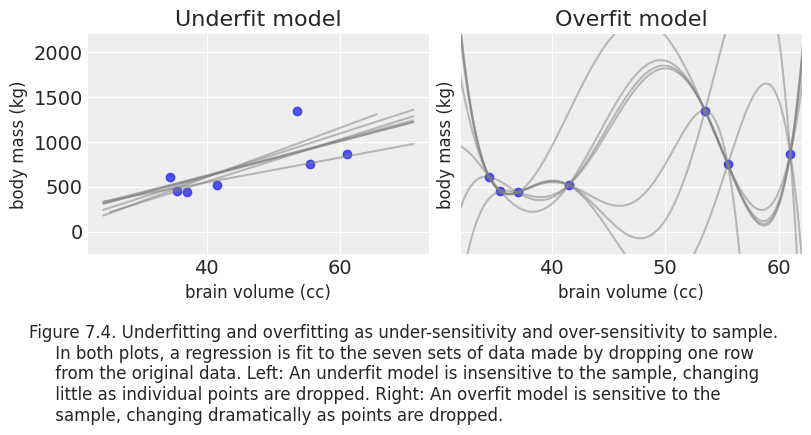

In [ ]:
# Figure 7.4

# this code taken from PyMC port of Rethinking/Chp_06.ipynb

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 3))
ax1.scatter(brains.mass, brains.brain, alpha=0.8)
ax2.scatter(brains.mass, brains.brain, alpha=0.8)
for i in range(len(brains)):
    d_new = brains.drop(brains.index[-i])  # drop each data point in turn

    # first order model
    m0 = smf.ols("brain ~ mass", d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax1.set_ylabel("body mass (kg)", fontsize=12)
    ax1.set_xlabel("brain volume (cc)", fontsize=12)
    ax1.set_title("Underfit model")

    # fifth order model
    m1 = smf.ols(
        "brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)", data=d_new
    ).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 200)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax2.set_xlim(32, 62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel("body mass (kg)", fontsize=12)
    ax2.set_xlabel("brain volume (cc)", fontsize=12)
    ax2.set_title("Overfit model")


#####################
### CODE ADDITION ###
#####################
plt.suptitle(
    x=0.5,
    y=-0.06,
    t="Figure 7.4. Underfitting and overfitting as under-sensitivity and over-sensitivity to sample. \n \
    In both plots, a regression is fit to the seven sets of data made by dropping one row \n \
    from the original data. Left: An underfit model is insensitive to the sample, changing \n \
    little as individual points are dropped. Right: An overfit model is sensitive to the \n \
    sample, changing dramatically as points are dropped.",
    ma="left"
  );

### **Rethinking: Bias and variance.**

The struggle between underfitting and overfitting is often discussed using the terminology of the **bias-variance trade-off** . While not perfectly identical concepts, they address the exact same problem: **Bias** is related to the problem of **underfitting**, and **variance** is related to **overfitting**. However, these terms can be confusing because they are used inconsistently across different areas of statistics . Furthermore, the word "bias" sounds inherently bad, even though **increasing bias** (simplifying the model) often leads to *better predictions* for new data. Because of this potential for confusion, we prefer the clearer terms of **underfitting** and **overfitting**, though you should expect to encounter the bias-variance trade-off used to describe these issues elsewhere.

## ***Section 7.2* -  Entropy and accuracy.**

How do we choose the right model—one that avoids the extreme problems of **overfitting** (learning too much) and **underfitting** (learning too little)?

The first step is to choose a **criterion for model performance** which is the *target* for what we want the model to do well. Information theory provides a natural and very useful way to measure this. Our path forward involves three main steps:

1. First, we need to use information theory to establish a measurement scale called **deviance** which tells us the distance of our model's predictions from perfect accuracy. In other words just like in supervised learning, we need to see how much our model's predictions on the training data *deviate* from the true outcome.

2. Second, we establish that it is only the deviance when applied to **new, unseen data (out-of-sample deviance)** that actually matters. This is equivalent to the "test" data to see if our model was able to generalize to data that it's never seen before.

3. Once we have deviance as our performance measure, we can use techniques like **regularization** and **information criteria** (which are built on this idea) to improve and estimate how well our model will predict the future.

This subject is complex, so if you feel confused at first, that's okay!

In [ ]:
def map_observed_weather(day):
    """Maps day number to observed weather emoji (🌧️ for days 1-3, ☀️ for days 4-10)."""
    if day <= 3:
        # We now use the unpadded emoji and let pandas handle spacing
        return '🌧️'
    else:
        return '☀️'

# --- Data Generation ---
days = np.arange(1, 11)
observed_weather = [map_observed_weather(d) for d in days]
column_headers = [str(d) for d in days]

### **7.2.1. Firing the weatherperson.**

When trying to judge a model's **accuracy**, we first need to define *what exactly do we want the model to succeed at*? There isn't one universally best target, and in defining one, we have to consider two major dimensions:

1. First, there is the **cost-benefit analysis** where we must formally determine what we lose when the model is wrong (the cost) and what we gain when it's right (the benefit). While many scientists ignore this formal analysis, people in applied fields must deal with these trade-offs all the time.

2. Second, we need to think about **accuracy in context**. Some prediction problems are inherently easier than others. Even if we completely ignore costs and benefits, we still need a way to judge "accuracy" that accounts for the maximum amount a model could realistically improve its prediction.

To help explore these two dimensions, let's look at an example involving a weatherperson named Bill who issues uncertain predictions for rain or shine as a <u>probability of rain</u> (i.e. the values in the `prediction` row) over a 10-day period:

In [ ]:
def create_table_m7_1_prediction():
    """Recreates the table where the Prediction changes from 1 to 0.6 (Image 2)."""
    predictions = [1, 1, 1, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
    data = {"Observed": observed_weather, "Bill's Prediction": predictions}
    df = pd.DataFrame(data).T
    df.columns = days
    return df


create_table_m7_1_prediction()

,1,2,3,4,5,6,7,8,9,10
Observed,🌧️,🌧️,🌧️,☀️,☀️,☀️,☀️,☀️,☀️,☀️
Bill's Prediction,1.0,1.0,1.0,0.6,0.6,0.6,0.6,0.6,0.6,0.6


Now let's say an average Joe comes in and boasts that he can beat the current weather man's prediction by always predicting sunshine (i.e. all predictions = 0). This person's record would therefore be:

In [ ]:
def create_table_m7_2_prediction():
    """Recreates the table where the Prediction is always 0 (Image 1)."""
    predictions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    data = {"Observed": observed_weather, "Joe's Predictions": predictions}
    df = pd.DataFrame(data).T
    df.columns = column_headers
    df = pd.DataFrame(data).T
    df.columns = days
    return df


create_table_m7_2_prediction()

,1,2,3,4,5,6,7,8,9,10
Observed,🌧️,🌧️,🌧️,☀️,☀️,☀️,☀️,☀️,☀️,☀️
Joe's Predictions,0,0,0,0,0,0,0,0,0,0


The newcomer, Joe, declared they were the best person for the job based solely on their rate of correct prediction. To measure this, we define the **hit rate** as the average chance of being right. The current weatherperson, Bill, had $3 \times 1 + 7 \times 0.4 = 5.8$ total hits over 10 days, resulting in a rate of 58% correct predictions per day.

As a reminder, $1$ in the equation means the prediction was 100% accurate so if Bill was 60% sure that it was going to rain and he was right, that would be $0.6$ times the number of days he was correct with this prediction. However if he was wrong, the number would be $0.4$ times the number of days he was wrong ($1 - 0.6 = 0.4$).

In contrast, Joe's strategy yielded $3 \times 0 + 7 \times 1 = 7$ total hits, for a rate of 70% correct predictions per day. Therefore, simply based on the measure of hit rate alone, our average Joe is declared the winner!

#### **7.2.1.1. Costs and benefits.**

While average Joe *technically* had the better prediction model based on our previous criteria, it's actually foolish not to take into consideration the real world **costs and benefits** that come with our **criterion of model preformance** and will lead to unintended outcomes.

Let's imagine you hate getting caught in the rain (a cost of **-5 points of happiness**), but you also hate carrying an umbrella when it's sunny (a cost of **-1 point of happiness**). Critically, let's assume your chance of carrying an umbrella is equal to the weatherperson's forecasted probability of rain (i.e. $p(umbrella) = p(rain)$). Your new goal is to <u>maximize total happiness points</u> (rather than strictly accuracy) by choosing a weatherperson. Now we need to look at the points you'd earn following either the current weatherperson, Bill's, forecast or the newcomer, Joe's, predictions:

In [ ]:
def create_table_points_comparison():
    """
    Recreates the table comparing points awarded to 'Current' and 'Newcomer' models (Image 3).
    The index names ('Current', 'Newcomer') represent the 'Points' rows.
    """
    current_points = [-1, -1, -1, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6]
    newcomer_points = [-5, -5, -5, 0, 0, 0, 0, 0, 0, 0]

    # Organize data so 'Observed', 'Current', and 'Newcomer' are row indices
    data = {
        "Observed": observed_weather,
        "Bill's Predictions": current_points,
        "Joe's Predictions": newcomer_points
    }

    df = pd.DataFrame(data).T
    df.columns = days
    return df


create_table_points_comparison()

,1,2,3,4,5,6,7,8,9,10
Observed,🌧️,🌧️,🌧️,☀️,☀️,☀️,☀️,☀️,☀️,☀️
Bill's Predictions,-1.0,-1.0,-1.0,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6
Joe's Predictions,-5,-5,-5,0,0,0,0,0,0,0


Following Bill's predictions nets you a total of $3 \times (-1) + 7 \times (-0.6) = \mathbf{-7.2}$ happiness points. Meanwhile, Joe's perfect but naive predictions only nets you $3 \times (-5) + 7 \times (0) = \mathbf{-15}$ happiness points because they guarantee that you will be unprepared every time it rains. This demonstrates that if we consider the actual consequences (the cost of being wet), the simple "rate of correct prediction" is a poor way to judge a model, and the newcomer, Joe, is clearly the inferior choice.

#### **7.2.1.2. Measuring accuracy.**

Even if we completely ignore the costs and benefits of a forecast, there's still confusion over which measure of "accuracy" we should adopt, since the simple "hit rate" is flawed. The crucial question is: which definition of accuracy is **maximized by the true model** that generated the data? We can't do better than that.

The answer lies in calculating the **joint probability** of predicting the exact sequence of outcomes. This means taking the probability of a correct prediction for each individual day and multiplying them all together. This joint probability is the same thing as the **likelihood** you use in Bayes' theorem, and it is the only definition of accuracy that is maximized by the true model.

When we use this measure, the newcomer looks even worse. His predictions—which never expected rain—result in a joint probability of zero ($0^3 \times 1^7 = 0$) because he assigned zero probability to events that actually happened. While the newcomer had a high *average* probability of being correct (hit rate), his joint probability is terrible. The joint probability is the measure we want because it correctly reflects the relative number of ways an entire sequence of events could occur. Maximizing the hit rate, as we saw, encourages models to make clearly wrong predictions (like always predicting zero rain), but the true model will always have the highest joint probability.

In statistics, this powerful measure of accuracy is often called the **log scoring rule**, because we typically compute the logarithm of the joint probability to report the final value.

### **Rethinking: What is a true model?**

When we talk about "true" probabilities, the concept is tricky because we know that *all models are ultimately false*. So in this context, "truth" doesn't mean perfect reality: It means *the right probabilities, given the limits of our knowledge.*

Another way to phrase this knowledge limitation is to describe our model as our **state of ignorance**. The probability isn't actually in the world itself, but rather within our model. If we had all the relevant information about a system (say, the exact physics of a coin toss), the outcome would be completely deterministic and the "true" probabilities would just be 0 (impossible) or 1 (certain). However, since we always lack some relevant information, all outcomes in our simplified model become uncertain, leading us to use "true" probabilities that fall somewhere between zero and one.

A good way to illustrate this concept is the globe toss example we went over in [Chapter 2](https://vanislekahuna.github.io/Statistical-Rethinking-PyMC/Chp_02.html) where if before we caught it, the outcome (landing on land or water) is uncertain. Based on our simple model, there is a "true" probability of hitting water. But if we knew every tiny detail of the physics of the globe toss, such as the speed, the angle, and the air currents, the outcome would be certain.

However because we are ignorant of all those physical details, the "true" probability is simply *the average over all the factors we don't know about the globe toss*, such as the physics of the toss. Our ignorance about those physical details is what makes us use a probability model in the first place and in this case, the right answer for our model is about 70% water.

> So in summary, if we know the physics of a phenomena or had complete information over an event then the outcome can be predicted deterministically. Any time we lack complete information, we can characterize the "true" probability of an event as an accurate and unbiased representation given our incomplete knowledge.

So far, the only thing that contradicts this idea are quantum events because randomness seems to be a physical feature of reality from a subatomic level.

### **7.2.2. Information and uncertainty.**

We need a way to measure how far a model's prediction is from the "true" probability of an outcome . Since this isn't obvious, we turn to **Information Theory**, a field developed in the 1940s to solve communication problems, which provides a unique and optimal solution.

The fundamental idea of Information Theory is to ask:

> How much is our uncertainty reduced when we learn the outcome?

In fact, **information** can actually be defined as *the reduction in uncertainty when we learn an outcome.*

Before the day, the weather is uncertain. But once the day ends, the outcome is known. The reduction in uncertainty is a natural measure of how much we learned, or the "information" we derived. If we can precisely define and quantify uncertainty, we can set a baseline for how hard a prediction task is, which then tells us how much improvement is possible.

To quantify uncertainty, we look for a mathematical function, called **Information Entropy**, that satisfies **3** common-sense rules:
1.  **Continuity:** Small changes in probability should only cause small changes in uncertainty.
2.  **Increased Events = Increased Uncertainty:** Uncertainty must go up if there are more possible outcomes to predict. For example, if an area such as Manila only experiences either rain or sun while Vancouver experiences rain, sun, *and* snow then we can tangibly say there is more uncertainty in predicting Vancouver weather since there's a higher range of outcomes.
3.  **Additivity:** The total uncertainty of two independent events (like weather and temperature) must equal the sum of their individual uncertainties.

**Information entropy** is the one function that meets these requirements:

$H(p) = -E \log(p_i) = -\sum_{i=1}^{n} p_i \log(p_i)$

In plain words, **information entropy** maintains that uncertainty in a set of probabilities is the **average log-probability of an event**. While the formula looks complicated, each part of it is entirely necessary as they're derived from each of the three rules we just outlined with information entropy.

For example, if the true probabilities of rain and shine are 30% ($p_1=0.3$) and 70% ($p_2=0.7$), then the <u>total uncertainty</u>, $H(p)$, is approximately $0.61$:

$H(p) = -\sum_{i=1}^{n} p_i \log(p_i) = -\sum_{i=1}^{n} p_i \ln(p_i)$

$ H(p) = -(p_1\log(p_1) + p_2\log(p_2)) $

$ H(p) = -(0.3 \cdot \log(0.3) + 0.7 \cdot \log(0.7)) $

$ H(p) = -( (0.30 + (-1.2040)) + (0.70 + (-0.3567)) )$

$ H(p) = 0.6108643020548935 \approx 0.61$


As a reminder, $\log()$ can also equal $\ln ()$ which stands for natural logarithms with a base of $e$: $ \log_e x $

This depends on the context. In introductory algebra, $\log(x)$ usually stands for the **common log** with a base of $10$. However in many other fields such as physics and in most programming languages used in data science, $\log(x)$ almost always refers to the **natural logarithm** with a base of $e$ (i.e. $2.718...$).

In [ ]:
# For example: World model example
print(f"Log(0.3) = e^-1.20240 = {math.e**(-1.2040)} \n")
print(f"Log(0.7) = e^−0.3567 = {math.e**(-0.3567)}")

Log(0.3) = e^-1.20240 = 0.29999184140872054 

Log(0.7) = e^−0.3567 = 0.699982460976843


Note that Information Entropy $H(p)$ may seem similar to the way we calculate the Probability of the Evidence $P(E)$ denominator derived from Bayes' Theorem, but the two are fundamentally different concepts. The denominator $P(E)$ in Bayes' Theorem represents the total probability of a specific outcome, and in information theory terms, this probability tells you how *surprising that specific outcome is*.

In contrast, Information Entropy $H(p)$ is the average surprise across all possible outcomes in a distribution. While $P(E)$ quantifies the rarity of a single event, Information Entropy quantifies the overall level of uncertainty or 'orderedness' of the entire system. For example when calculating information entropy, you use $P(E)$ and $1 - P(E)$, or $P(\text{not } E)$ in other words, as the inputs to calculate $H(p)$. **Information Entropy** is essentially the "expected value" of the surprises of every possible evidence outcome.

To summarize:
- **Scope**: $P(E)$ is a point value for one specific result (e.g., "The test was positive"). $H(p)$ is a system-wide average for all results (e.g., "How uncertain is this test in general?").
- **Units**: $P(E)$ is a probability between 0 and 1. $H(p)$ is measured in bits or nats (units of information).
- **Relationship**: You use $P(E)$ and $P(\text{not } E)$ as the inputs to calculate $H(p)$. Entropy is essentially the "expected value" of the surprises of every possible evidence outcome.

#### Code 7.12

In [ ]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

np.float64(0.6108643020548935)

In [ ]:
print(f"-( ({p[0]:.2f} + {np.log(p[0]):.4f}) + ({p[1]:.2f} + {np.log(p[1]):.4f}) )")

-( (0.30 + -1.2040) + (0.70 + -0.3567) )


On the flip side, if we lived in Abu Dhabi where the probability of rain is $p = 0.01$ while the probability of sun equals $p = 0.99$ then the uncertainty of our prediction would be about $0.06$:

In [ ]:
a = np.array([0.01, 0.99])
uncertainty = -np.sum(a * np.log(a))
print(f"{uncertainty} = -( ({a[0]:.2f} + {np.log(a[0]):.4f}) + ({a[1]:.2f} + {np.log(a[1]):.4f}) )")

0.056001534354847345 = -( (0.01 + -4.6052) + (0.99 + -0.0101) )


### **Overthinking: More on entropy.**

To reiterate, **Information Entropy** is essentially the average log-probability of an event. However, mathematically we must multiply this value by $-1$ simply to ensure the resulting entropy, $H(p)$, increases from zero rather than decreasing, which is a matter of mathematical convention.

The specific base of the logarithm doesn't functionally change our results, <u>as long as we use the same base</u>, whether it’s the natural log (base $e$) or the binary log (base 2), for all the models we compare.

The only computational wrinkle arises when a probability $p_i$ is zero. Since the logarithm of zero is negative infinity ($\log(0) = -\infty$), we can't use it. However, **L'H&ocirc;pital's rule** tells us that the limit of $p_i \log(p_i)$ as $p_i$ approaches $0$ is $0$:

$ \text{lim}_{p_i \rightarrow 0} p_i \log(p_i) = 0 $

Therefore given L'H&ocirc;pital's rule, we can just assume that $0 \log(0) = 0$ when calculating $H$. This means that any event that never happens drops out of the calculation which reinforces the idea that *if an event never occurs, there is no value in keeping it in the model*.

### **Rethinking: The benefits of maximizing uncertainty.**

A highly important application of information theory is a technique called **Maximum Entropy**, or "**MaxEnt**" . This technique is used to find the probability distribution that is the *least surprising* and most consistent with the information we already possess.

In simpler terms, given what we know, MaxEnt finds the probability distribution that assumes the minimum possible amount of additional information.

When you use your prior knowledge as a constraint and maximize the information entropy, the distribution you end up with is actually the **posterior distribution** from a Bayesian analysis. This means that **Bayesian updating is fundamentally a process of entropy maximization**. Maximum Entropy is a powerful concept that we will use later in Chapter 10 to help us build more complex statistical models, like generalized linear models (GLMs).

### **7.2.3. From entropy to accuracy.**

Since we now have **information entropy** ($H$) to precisely quantify uncertainty, we can use it to measure the **distance** a model's prediction is from the target's true probability. This measure is called **Divergence**, specifically the **Kullback-Leibler (K-L) Divergence** . **Divergence** is the additional uncertainty that we create by using the probabilities from our approximating model ($q$) to describe the true probability distribution ($p$).

The K-L Divergence formula calculates this distance through the *average difference in log probability between the target ($p$) and our model's approximation ($q$)*:

$$ D_{KL}(p, q) = \sum_{i} p_i ( \text{log}(p_i) - \text{log}(q_i)) = \sum_{i} p_i \text{log}(\frac{p_i}{q_i}) $$

When our model's probabilities are exactly the same as the target's probabilities ($p=q$), the divergence is zero — meaning no additional uncertainty is induced. Another way to put is if $ D_{KL}(p, q) = 0 $ then it means that our model ($q$) predicts an outcome ($p$) with perfect accuracy ever time.

However, as our approximating model ($q$) gets further away from the true target ($p$), the divergence **always increases**, never falling below zero.  

Therefore, when comparing different models, the candidate that **minimizes the divergence** is the one that is closest to the target distribution and provides the most accurate prediction of observations.

### Figure 7.5. Information divergence of an approximating distribution $q$ from a 'true distribution' $p$.

Text(1.31, 0.7, 'Figure 7.5. Information divergence of an \n     approximating distribution q from a true \n     distribution p. Divergence can only equal \n     zero when q = p (dashed line). Otherwise, the \n     divergence is positive and grows as q becomes  \n     more dissimilar from p. When we have more  \n     than one candidate approximation q, the q  \n     with the smallest divergence is the most  \n     accurate approximation, in the sense that it  \n     induces the least additional uncertainty.')

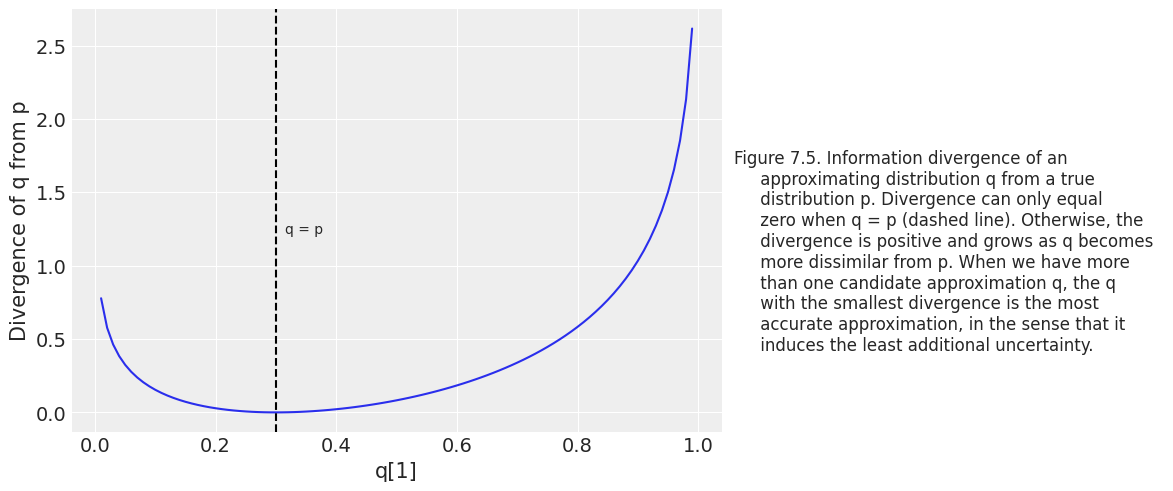

In [ ]:
p = np.array([0.3, 0.7])
q = np.arange(0.01, 1, 0.01)
DKL = np.sum(p * np.log(p / np.array([q, 1 - q]).T), 1)

plt.plot(q, DKL)
plt.xlabel("q[1]")
plt.ylabel("Divergence of q from p")
plt.axvline(0.3, ls="dashed", color="k")
plt.text(0.315, 1.22, "q = p")

#####################
### CODE ADDITION ###
#####################
plt.suptitle(
    x=1.31,
    y=.7,
    t="Figure 7.5. Information divergence of an \n \
    approximating distribution q from a true \n \
    distribution p. Divergence can only equal \n \
    zero when q = p (dashed line). Otherwise, the \n \
    divergence is positive and grows as q becomes  \n \
    more dissimilar from p. When we have more  \n \
    than one candidate approximation q, the q  \n \
    with the smallest divergence is the most  \n \
    accurate approximation, in the sense that it  \n \
    induces the least additional uncertainty.",
    ma="left"
  )

### **Overthinking: Cross entropy and divergence.**

Deriving the **Kullback-Leibler (K-L) Divergence** is conceptually easier than you might think, starting with something called Cross Entropy. **Cross entropy ($H(p, q)$)** is defined by realizing that when we use the probabilities from our model ($q$) to predict events that actually arise from the true distribution ($p$), the resulting uncertainty measure is inflated.

$ D_{KL}(p, q) = H(p, q) - H(p) $

$ D_{KL}(p, q) = \sum_{i} p_i \text{log}(q_i) - (\sum_{i} p_i ( \text{log}(q_i) - \text{log}(p_i))) $



This inflation happens because the probabilities we *expect* ($q$) are different from the probabilities that actually *generate the events* ($p$). The divergence is simply the measure of this **additional entropy** that we've introduced by using the wrong distribution ($q$).

Therefore, the K-L Divergence is calculated as the difference between the target's true entropy, $H(p)$, and the cross entropy, $H(p, q)$. This confirms that divergence truly measures how far our model ($q$) is from the target ($p$), using units of entropy. It is important to note that the order matters: the cross entropy from $H(p, q)$ is generally not equal to $H(q, p)$.

### **Rethinking: Divergence depends upon direction.**

In general, **Cross Entropy** ($H(p, q)$) is not equal to $H(q, p)$, meaning the direction you calculate divergence in matters. To understand why this asymmetry exists, let's use the analogy of predicting a landing spot on Mars versus Earth

If we use Earth's probabilities (70% water, 30% land) to predict a landing on Mars (which is 1% water, 99% land), the resulting divergence (the additional uncertainty) is $D_{E → M} = D_{KL}(p, q) = 1.14$. When we reverse the process and use Mars's dry probabilities (99% land) to predict a landing on Earth, the divergence jumps to $D_{M → E} = D_{KL}(q, p) = 2.62$.

This difference is a feature, not a bug. The divergence is longer from Mars to Earth because the Martian distribution is very extreme as it assigns almost zero probability to water (1%). When we use this extreme "Mars model" to predict Earth, where we are highly likely to land in water, the model is **enormously surprised**, leading to a huge increase in calculated uncertainty (a high divergence). Conversely, when we use the "Earth model" to predict Mars, the Earth model already expects *some* land (30%), so it's less surprised when we inevitably land on Mars's dry surface.

A crucial practical result of this asymmetry is that if we use a model (the approximating distribution) that has **high entropy** (meaning it's more uncertain and spreads probability out), it will reduce the distance to the truth and therefore reduce our error. This concept is fundamental and will be very useful later when we construct generalized linear models.

### **7.2.4. Estimating divergence.**

You might be wondering where all this information theory is leading us, especially since we started talking about fixing overfitting and underfitting

This detour was absolutely necessary because it accomplished both:

1. A precise way to measure the distance of any model from the true target. The distance measure we need here is the **Kullback-Leibler (K-L) Divergence**.

2. A way to estimate this divergence in a real-world setting. K-L Divergence leads directly to a measure of model fit called **deviance**. The challenge is that to calculate divergence exactly, we would need to know $p$, the "true" probability distribution. But if we knew the truth, we wouldn't need statistical inference in the first place!

Fortunately, there's an amazing shortcut. Since we are only interested in *comparing* the distances of different candidate models (say, model $q$ versus model $r$), most of the unknown information about $p$ cancels out. This means we can estimate how far apart $q$ and $r$ are, and which one is closer to the target, even without knowing where the target is located.

This shortcut reveals that all we need to know is each model's **average log-probability**: $\sum\log(q_i)$ for $q$ and $\sum\log(r_i)$ for $r$. In practice, we estimate this by calculating the **total log-probability score** which is simply the sum of the log-probabilities for every observed data point in our sample. It is an estimate of $\sum\log(q_i)$ except without the step of dividing by the number of observations. This log-probability score is the gold standard for comparing the predictive accuracy of models:

$$ S(q) = \sum_i \text{log}(q_i) $$

A crucial point is that for Bayesian models, you must calculate this score using the **entire posterior distribution**... Not just the single best-fit parameters. Failing to use the full distribution means throwing away information. To do this correctly, we must find the log of the *average probability* for each observation, where that average is taken over the posterior distribution. We use specialized functions, like `lppd` (**log-pointwise-predictive-density**), to perform this subtle, correct calculation:

#### Code 7.13 & 7.14

When we look at the list of log-probability scores, each value represents the average log-probability for a single observation (one of the seven data points in our example). If you sum up all these individual values, you get the model's **total log-probability score**. The meaning of this total score is simple: **larger values are better**, as a higher score indicates greater average predictive accuracy, meaning the model is closer to the true outcome.

It is also very common in statistics to see something called the **deviance**. The deviance is simply the log-probability score multiplied by **$-2$**. This convention means that, unlike the log-probability score, a **smaller deviance value is better**. The reason for multiplying by 2 is purely historical, but it is a standard practice you will encounter often.

### **Overthinking: Computing the lppd.**

The Bayesian version of the log-probability score is called the **log-pointwise-predictive-density (lppd)** . The idea is to calculate the probability of each observation ($y_i$), averaged across *all* the possible parameter values in the posterior distribution ($\theta_s$) and then take the logarithm of that average.

The formula looks like this:

$$\text{lppd} = \sum_i \text{log} \frac{1}{S} \sum_s p(y_i | \theta_s ) $$


Additional information you'll need to know is that $S$ is the number of samples and that $\theta_s$ is the $s$-th set of sampled parameter values in the posterior. In principle, this should be easy. For each observation, you calculate its probability using every sample from the posterior, average those probabilities, and then take the log. However in practice, computers struggle to maintain numerical precision when dealing with very small probabilities so it's much safer to do all the heavy lifting on the **log-probability scale**.

To achieve this numerically stable calculation, we use a specific function called `log_sum_exp`. This function takes all the log-probabilities for an observation, safely exponentiates them (undoing the log), sums them up, and then immediately takes the logarithm again.

```
def manual_logsumexp(x):
    """
    A manual implementation of the log-sum-exp trick.
    """
    # 1. Find the maximum value in the array
    a = np.max(x)
    
    # 2. Subtract 'a' from every element, exponentiate, then sum them all.
    # This is safe because (x - a) will always be <= 0.
    # e^0 is 1, and e^(negative) is between 0 and 1.
    sum_of_exps = np.sum(np.exp(x - a))
    
    # 3. Take the log and add back 'a'
    return a + np.log(sum_of_exps)
```

This is the first part of the formula, $ \sum_i \text{log} \left( \sum_s p(y_i | \theta_s ) \right) $. Then, we subtract the log of the number of samples, which is the mathematical equivalent of dividing the sum by the number of samples ($\frac{1}{S}$), giving us the final, stable result for each data point.


<!--- $\log(\sum_s p(y_i | \theta_s))$ --->

In [ ]:
n_samples = 3000

intercept, slope = stats.multivariate_normal(m_7_1.params, m_7_1.cov_params()).rvs(n_samples).T
print(f"Intercept: {intercept.shape} \n")
print(f"Slope: \n {slope} \n\n")

pred = intercept + slope * brains.mass_std.values.reshape(-1, 1)
print(f"Prediction: \n {pred} \n\n")

n, ns = pred.shape
print(f"Prediction Shape: ({pred.shape})")

Intercept: (3000,) 

Slope: 
 [0.05027375 0.17063491 0.1609586  ... 0.23007378 0.10393051 0.14746286] 


Prediction: 
 [[0.61030297 0.46330477 0.45288618 ... 0.39473726 0.4619737  0.40873754]
 [0.60338766 0.43983344 0.43074585 ... 0.36308994 0.44767776 0.38845359]
 [0.59877746 0.42418588 0.41598563 ... 0.34199172 0.43814712 0.37493095]
 ...
 [0.69559169 0.75278457 0.72595024 ... 0.78505429 0.63829039 0.65890626]
 [0.7209478  0.83884613 0.80713144 ... 0.90109448 0.69070886 0.73328074]
 [0.68637129 0.72148946 0.6964298  ... 0.74285785 0.61922913 0.63186099]] 


Prediction Shape: ((7, 3000))


In [ ]:
# PyMC does not have a way to calculate LPPD directly, so we use the approach from 7.14

sigmas = (
  np.sum(
      (pred - brains.brain_std.values.reshape(-1, 1))**2,
      0
    ) / 7
) ** 0.5

ll = np.zeros((n, ns))
for s in range(ns):
    logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
    ll[:, s] = logprob

lppd = np.zeros(n)
for i in range(n):
    lppd[i] = logsumexp(ll[i]) - np.log(ns)

lppd

array([ 0.62060273,  0.66080837,  0.56608632,  0.62876608,  0.47909493,
        0.44851465, -0.8559313 ])

In [ ]:
def calculate_lppd_pymc(InferenceData, observed_data):
    """
    Calculates the Log-Pointwise-Predictive-Density (LPPD) from a PyMC
    InferenceData object.

    Args:
        InferenceData: The trace returned by pm.sample().
        observed_data (np.ndarray): The actual observed values (y).

    Returns:
        np.ndarray: A vector of LPPD values, one for each observation.
    """

    # 1. Ensure log_likelihood is present in the InferenceData
    InferenceData = pm.compute_log_likelihood(InferenceData)
    if 'log_likelihood' not in InferenceData:
        raise ValueError(
            "InferenceData does not contain log_likelihood. "
            "Ensure you defined a 'name' for your likelihood in pm.Normal "
            "and either used pm.sample(..., compute_log_likelihood=True) "
            "or run pm.compute_log_likelihood(InferenceData) first."
        )

    # 2. Extract the log-likelihood values
    # PyMC/ArviZ stores these as (chain, draw, observation)
    # We combine chains and draws into a single 'samples' dimension
    log_lik = az.extract(InferenceData, group="log_likelihood")

    # Get the name of the likelihood variable (usually it's the only one)
    var_name = list(log_lik.data_vars)[0]
    ll_matrix = log_lik[var_name].values # Shape: (n_observations, n_samples)

    n_obs, n_samples = ll_matrix.shape

    # 3. Apply the LPPD formula using logsumexp for stability
    # lppd_i = log( (1/S) * sum( exp(ll_is) ) )
    # which is: logsumexp(ll_i) - log(S)
    lppd = np.zeros(n_obs)
    for i in range(n_obs):
        lppd[i] = logsumexp(ll_matrix[i, :]) - np.log(n_samples)

    return lppd

In [ ]:
with pm.Model() as m_7_1_pymc:
    # Priors
    a = pm.Normal("a", 0.5, 1)
    b = pm.Normal("b", 0, 10)
    sigma = pm.LogNormal("sigma", 0, 1)

    # Likelihood (Give it a name so we can extract log_likelihood)
    mu = a + b * brains.mass_std.values
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=brains.brain_std.values)

    # Inference
    trace = pm.sample(1000, return_inferencedata=True, compute_log_likelihood=True)

    # Calculate
    lppd_scores = calculate_lppd_pymc(trace, brains.brain_std.values)
    print(f"Total LPPD: {lppd_scores.sum()}")

Output()

Output()

Total LPPD: 1.3163221857531893


### **7.2.5. Scoring the right data.**



#### Code 7.15

While the log-probability score provides a mathematically principled way to measure a model's distance from the truth, the version we have calculated so far suffers from the exact same flaw as $R^2$. It consistently improves as the model becomes more complex, regardless of whether that complexity is actually helpful for understanding the underlying phenomenon. This happens because log-probability calculated on the training data is strictly a measure of **retrodictive accuracy** which is how well the model can "predict" the data it has already seen—rather than **predictive accuracy**, which is how well it will perform on new, unseen data. Just as adding parameters allows $R^2$ to climb toward perfection by chasing noise, it also allows the log-probability score to increase, creating a false sense of security about the model's quality. To truly understand a model's value, we must look beyond its ability to describe the past and find ways to estimate how it will handle the future.

Let’s compute the log-score for each of the models from earlier in this chapter:

In [ ]:
# make an lppd function that can be applied to all models (from code above)
def lppd(model, n_samples=1e4):
    n_samples = int(n_samples)

    pars = stats.multivariate_normal(model.params, model.cov_params()).rvs(n_samples).T
    dmat = dmatrix(
        model.model.data.design_info, brains, return_type="dataframe"
    ).values  # get model design matrix
    pred = dmat.dot(pars)

    n, ns = pred.shape

    # this approach for calculating lppd isfrom 7.14
    sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
    ll = np.zeros((n, ns))
    for s in range(ns):
        logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
        ll[:, s] = logprob

    lppd = np.zeros(n)
    for i in range(n):
        lppd[i] = logsumexp(ll[i]) - np.log(ns)

    return lppd

In [ ]:
# model 7_6 does not work with OLS because its covariance matrix is not finite.
lppds = np.array(list(map(lppd, models[:-1], [1000] * len(models[:-1]))))

lppds.sum(1)

array([ 2.54799078,  2.3115561 ,  2.89843278,  3.53621752, 11.04367575])

As you can see, the more complex models achieve higher scores, yet we already know those models are fundamentally flawed for these data. This serves as a stark reminder that we simply cannot judge models based solely on their performance with training data; to do so is to invite the disaster of overfitting. What truly matters is how a model performs on new, unseen data.

To bring this challenge into focus, we can use a thought experiment to simulate scores both in and out of sample. Imagine we have a training sample of size $N$ which we use to estimate our model's parameters and calculate a training score of $D_{train}$. Then, imagine a second "test" sample of the same size $N$ generated by the exact same process. By using the model we built from the first sample to predict the outcomes of the second, we can calculate a test score,  $D_{test}$. This procedure allows us to precisely measure the gap between retrodictive accuracy, which is how well we describe the past, and predictive accuracy which is how well we navigate the future.

To visualize how accuracy behaves, we can conduct a thought experiment 10,000 times using five different linear regression models. In this simulation, the "truth" is generated by a model with only two predictors where we fit models ranging from one to five parameters to see how they perform. By calculating the deviance, we can track how well these models fit the data they were trained on ($D_{train}$) as compared to how well they predict entirely new samples ($D_{test}$).


$ y_i \sim \text{Normal}(\mu_i, 1) $

$ \mu_i = (0.15)x_{1,i} - (0.4)x_{2,i} $

The results in [Figure 7.6](#scrollTo=erHh2F4f-dXh) reveal a consistent pattern: As we add parameters, the training deviance always improves (gets smaller), mirroring the behavior of $R^2$. However, the out-of-sample deviance tells a different story. In a small sample of $ N = 20 $, the out-of-sample deviance is minimized at three parameters, which is the "true" model, then begins to get worse as additional parameters start fitting pure noise. Interestingly, with very little data, a simpler "false" model can sometimes out-predict a more complex "true" model because the simpler model avoids the high error caused by imprecise parameter estimates. As the sample size increases to $ N = 100 $, the models become better at identifying the true relationships, and the gap between training and test performance narrows.

The most important takeaway is that deviance is an assessment of **predictive accuracy**, not a direct measure of "truth." A model containing the correct variables isn't guaranteed to give the best predictions if the data is too sparse to estimate those variables accurately. These simulations demonstrate that while adding variables always makes a model look better on the data at hand, its performance on future data depends on a delicate balance between the complexity of the underlying process and the amount of evidence available. This tension forms the theoretical foundation for using both regularizing priors and information criteria to choose better models.

### **Overthinking: Simulating training and testing.**

We'll now use the next 3 code boxes from `7.16` - `7.18` tp reproduce the plot in [Figure 7.6](#scrollTo=erHh2F4f-dXh).

NOTE - I re-wrote these last three code boxes in order to produce a figure that matched that one in the book.


#### Code 7.16

This relies on the `sim.train.test` function in the `rethinking` package. [This](https://github.com/rmcelreath/rethinking/blob/master/R/sim_train_test.R) is the original function.

The python port of this function below is from [Rethinking/Chp_06](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb) Code 6.12.

In [ ]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100, samples=1000):
    """
    Simulate train and test deviance for a linear regression model.

    This function generates correlated multivariate normal data, fits a Bayesian
    linear regression model using PyMC, and computes the deviance (negative log
    likelihood) on both training and test sets.

    Parameters
    ----------
    N : int, default=20
        Sample size for both training and test datasets.
    k : int, default=3
        Number of parameters in the model (including intercept).
        Must be >= 2 (intercept + at least one predictor).
    rho : list of float, default=[0.15, -0.4]
        Correlation coefficients between the outcome variable (first column)
        and the first len(rho) predictor variables.
    b_sigma : float, default=100
        Prior standard deviation for the regression coefficients.
        The prior covariance matrix is b_sigma * I.
    samples : int, default=1000
        Number of MCMC samples to draw for posterior inference.

    Returns
    -------
    tuple of float
        (mean_train_deviance, mean_test_deviance)
        - mean_train_deviance: Average deviance on training data
        - mean_test_deviance: Average deviance on test data

    Notes
    -----
    - The function generates data with a correlation structure defined by rho
    - Deviance is computed as -2 * sum(log-likelihood)
    - The model includes an intercept term (column of ones) automatically

    Examples
    --------
    >>> train_dev, test_dev = sim_train_test(N=20, k=3, samples=500)
    >>> print(f"Train deviance: {train_dev:.2f}, Test deviance: {test_dev:.2f}")
    """

    # Determine the dimension of the data (need at least k dimensions)
    n_dim = max(k, 1 + len(rho))

    # Create correlation matrix
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:min(len(rho)+1, n_dim)] = rho[:min(len(rho), n_dim-1)]
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    # Generate training and test data
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    # Ensure x_train and x_test are 2D arrays
    if N == 1:
        x_train = x_train.reshape(1, -1)
        x_test = x_test.reshape(1, -1)

    # Create design matrix for training (intercept + k-1 predictors)
    mm_train = np.ones((N, 1))
    if k > 1:
        mm_train = np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

    # Fit Bayesian linear regression model using PyMC
    with pm.Model() as m_sim:
        vec_V = pm.MvNormal(
            "vec_V",
            mu=0,
            cov=b_sigma * np.eye(k),
            shape=(1, k),
            initval=np.random.randn(1, k) * 0.01,
        )
        mu = pm.Deterministic("mu", pm.math.dot(mm_train, vec_V.T))
        y = pm.Normal("y", mu=mu, sigma=1, observed=x_train[:, 0].reshape(-1, 1))

    # Sample from posterior
    with m_sim:
        trace_m_sim = pm.sample(samples, progressbar=False)

    # Extract posterior means of coefficients
    vec = az.summary(trace_m_sim)["mean"][:k].values
    vec = vec.reshape(k, -1)

    # Compute training deviance
    y_train_pred = np.matmul(mm_train, vec).flatten()
    dev_train = -2 * np.sum(stats.norm.logpdf(x_train[:, 0], loc=y_train_pred, scale=1))

    # Create design matrix for test data (intercept + k-1 predictors)
    mm_test = np.ones((N, 1))
    if k > 1:
        mm_test = np.concatenate([mm_test, x_test[:, 1:k]], axis=1)

    # Compute test deviance
    y_test_pred = np.matmul(mm_test, vec).flatten()
    dev_test = -2 * np.sum(stats.norm.logpdf(x_test[:, 0], loc=y_test_pred, scale=1))

    return dev_train, dev_test

In [ ]:
def run_simulation(n, tries=10, param=6):
    """
    Run simulations for different numbers of parameters.

    Parameters
    ----------
    n : int
        Sample size (N)
    tries : int
        Number of simulation runs per parameter value
    param : int
        Maximum number of parameters to test

    Returns
    -------
    tuple
        (num_param, r) where num_param is array of parameter counts
        and r is array of statistics (mean_train, std_train, mean_test, std_test)
    """
    r = np.zeros(shape=(param - 1, 4))

    for j in range(2, param + 1):
        print(f"N={n}, Num Params: {j}")
        train = []
        test = []

        for i in tqdm.tqdm(range(1, tries + 1)):
            tr, te = sim_train_test(N=n, k=j, samples=1000)
            train.append(tr)
            test.append(te)

        r[j - 2, :] = (
            np.mean(train),
            np.std(train, ddof=1),
            np.mean(test),
            np.std(test, ddof=1),
        )

    num_param = np.arange(2, param + 1)
    return num_param, r

In [ ]:
tries = 100
param = 6

# Setting log output to error
logger = logging.getLogger("pymc")
init_level = logger.level
logger.setLevel(logging.ERROR)

# Run simulations for N=20 and N=100
print("Running simulations for N=20...")
num_param_20, r_20 = run_simulation(n=20, tries=tries, param=param)

print("\nRunning simulations for N=100...")
num_param_100, r_100 = run_simulation(n=100, tries=tries, param=param)

# Reset logger level
logger.setLevel(init_level)

Running simulations for N=20...
N=20, Num Params: 2


100%|██████████| 100/100 [05:27<00:00,  3.28s/it]


N=20, Num Params: 3


100%|██████████| 100/100 [05:22<00:00,  3.23s/it]


N=20, Num Params: 4


100%|██████████| 100/100 [06:07<00:00,  3.67s/it]


N=20, Num Params: 5


100%|██████████| 100/100 [07:01<00:00,  4.22s/it]


N=20, Num Params: 6


100%|██████████| 100/100 [07:39<00:00,  4.60s/it]



Running simulations for N=100...
N=100, Num Params: 2


100%|██████████| 100/100 [06:27<00:00,  3.87s/it]


N=100, Num Params: 3


100%|██████████| 100/100 [06:54<00:00,  4.15s/it]


N=100, Num Params: 4


100%|██████████| 100/100 [07:21<00:00,  4.42s/it]


N=100, Num Params: 5


100%|██████████| 100/100 [07:51<00:00,  4.71s/it]


N=100, Num Params: 6


100%|██████████| 100/100 [09:25<00:00,  5.66s/it]


In [ ]:
def plot_deviance(ax, num_param, r, n):
    """
    Plot deviance in and out of sample for a given sample size.

    Parameters
    ----------
    ax : matplotlib axis
        Axis to plot on
    num_param : array
        Array of parameter counts
    r : array
        Statistics array (mean_train, std_train, mean_test, std_test)
    n : int
        Sample size for title
    """
    # Plot training data (in-sample)
    ax.scatter(num_param, r[:, 0], color='C0', s=50, zorder=3)

    for j in range(len(num_param)):
        ax.vlines(
            num_param[j],
            r[j, 0] - r[j, 1],
            r[j, 0] + r[j, 1],
            color='mediumblue',
            zorder=2,
            alpha=0.80,
            linewidth=2
        )

    # Plot test data (out-of-sample)
    offset = 0.05
    ax.scatter(num_param + offset, r[:, 2], facecolors='none', edgecolors='k', s=50, zorder=3)

    for j in range(len(num_param)):
        ax.vlines(
            num_param[j] + offset,
            r[j, 2] - r[j, 3],
            r[j, 2] + r[j, 3],
            color='k',
            zorder=1,
            alpha=0.70,
            linewidth=2
        )

    # Add labels
    dist = 0.20
    ax.text(num_param[1] - dist, r[1, 0], 'in', color='C0', fontsize=11)
    ax.text(num_param[1] + dist, r[1, 2], 'out', color='k', fontsize=11)
    ax.text(num_param[1] + dist*1.5, r[1, 2] + r[1, 3] + 5, '+1SD', color='k', fontsize=9)
    ax.text(num_param[1] + dist*1.5, r[1, 2] - r[1, 3] - 5, '+1SD', color='k', fontsize=9)

    # Set labels and title
    ax.set_xlabel('number of parameters', fontsize=12)
    ax.set_ylabel('deviance', fontsize=12)
    ax.set_title(f'N = {n}', fontsize=13)
    ax.set_xticks(num_param)

#### Code 7.17

Does not apply because multi-threading is automatic in PyMC.

### Figure 7.6. Deviance in and out of sample.

#### Code 7.18

/tmp/ipython-input-157320067.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


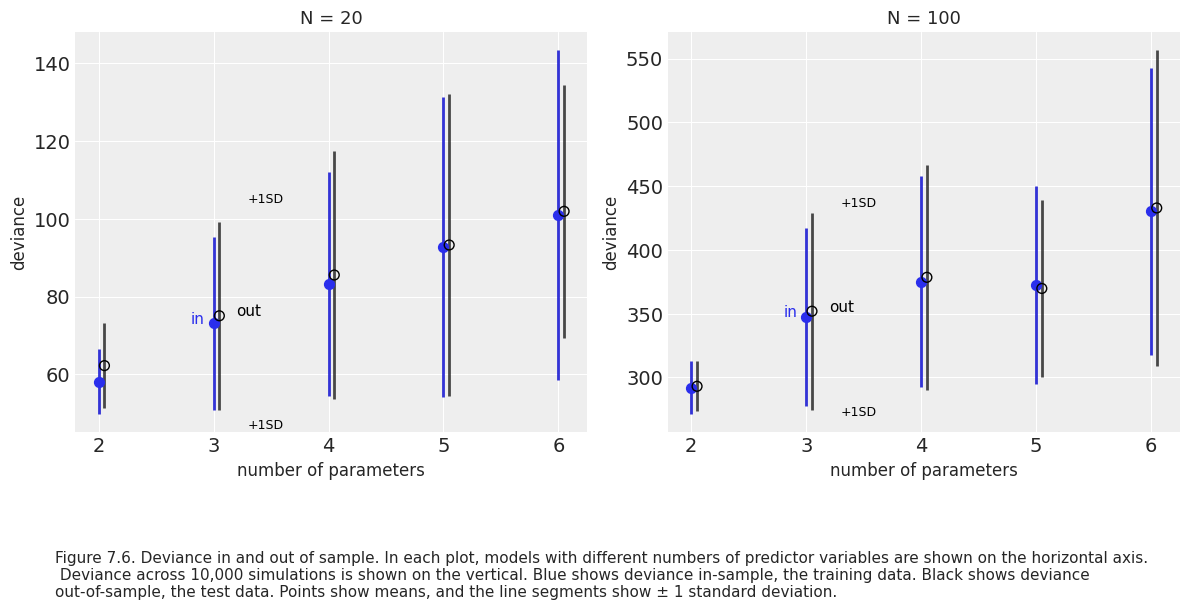

In [ ]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot both
plot_deviance(ax1, num_param_20, r_20, 20)
plot_deviance(ax2, num_param_100, r_100, 100)

# Add caption below the figure
caption = "Figure 7.6. Deviance in and out of sample. In each plot, models with different numbers of predictor variables are shown on the horizontal axis. \n \
Deviance across 10,000 simulations is shown on the vertical. Blue shows deviance in-sample, the training data. Black shows deviance out-of-sample, the test data. Points show means, and the line segments show ± 1 standard deviation."

fig.text(0.05, -0.2, caption, ha='left', fontsize=11, wrap=True)

plt.tight_layout()
plt.show()

In [ ]:
# def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100, samples=1000):

#     n_dim = 1 + len(rho)
#     if n_dim < k:
#         n_dim = k
#     Rho = np.diag(np.ones(n_dim))
#     Rho[0, 1:3:1] = rho
#     i_lower = np.tril_indices(n_dim, -1)
#     Rho[i_lower] = Rho.T[i_lower]

#     x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
#     x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

#     mm_train = np.ones((N, 1))

#     np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

#     # Using pymc
#     with pm.Model() as m_sim:
#         vec_V = pm.MvNormal(
#             "vec_V",
#             mu=0,
#             cov=b_sigma * np.eye(n_dim),
#             shape=(1, n_dim),
#             initval=np.random.randn(1, n_dim) * 0.01,
#         )
#         mu = pm.Deterministic("mu", 0 + pm.math.dot(x_train, vec_V.T))
#         y = pm.Normal("y", mu=mu, sigma=1, observed=x_train[:, 0].reshape(-1, 1))

#     with m_sim:
#         trace_m_sim = pm.sample(samples, progressbar=False)

#     vec = az.summary(trace_m_sim)["mean"][:n_dim]
#     vec = np.array([i for i in vec]).reshape(n_dim, -1)

#     dev_train = -2 * sum(stats.norm.logpdf(x_train, loc=np.matmul(x_train, vec), scale=1))

#     mm_test = np.ones((N, 1))

#     mm_test = np.concatenate([mm_test, x_test[:, 1 : k + 1]], axis=1)

#     dev_test = -2 * sum(stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1))

#     return np.mean(dev_train), np.mean(dev_test)

In [ ]:
# # This cell is expected have a long run time
# n = 20
# tries = 10
# param = 6
# r = np.zeros(shape=(param - 1, 4))

# train = []
# test = []

# # setting log output to error
# logger = logging.getLogger("pymc")
# init_level = logger.level
# logger.setLevel(logging.ERROR)

# for j in range(2, param + 1):
#     print(f"Num Params: {j}")
#     for i in tqdm.tqdm(range(1, tries + 1)):
#         tr, te = sim_train_test(N=n, k=param, samples=1000)
#         train.append(tr), test.append(te)
#     r[j - 2, :] = (
#         np.mean(train),
#         np.std(train, ddof=1),
#         np.mean(test),
#         np.std(test, ddof=1),
#     )

# # resetting logger level
# logger.setLevel(init_level)

In [ ]:
# num_param = np.arange(2, param + 1)

# plt.figure(figsize=(10, 6))
# plt.scatter(num_param, r[:, 0], color="C0")
# plt.xticks(num_param)

# for j in range(param - 1):
#     plt.vlines(
#         num_param[j],
#         r[j, 0] - r[j, 1],
#         r[j, 0] + r[j, 1],
#         color="mediumblue",
#         zorder=-1,
#         alpha=0.80,
#     )

# plt.scatter(num_param + 0.1, r[:, 2], facecolors="none", edgecolors="k")

# for j in range(param - 1):
#     plt.vlines(
#         num_param[j] + 0.1,
#         r[j, 2] - r[j, 3],
#         r[j, 2] + r[j, 3],
#         color="k",
#         zorder=-2,
#         alpha=0.70,
#     )

# dist = 0.20
# plt.text(num_param[1] - dist, r[1, 0] - dist, "in", color="C0", fontsize=13)
# plt.text(num_param[1] + dist, r[1, 2] - dist, "out", color="k", fontsize=13)
# plt.text(num_param[1] + dist, r[1, 2] + r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
# plt.text(num_param[1] + dist, r[1, 2] - r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
# plt.xlabel("Number of parameters", fontsize=14)
# plt.ylabel("Deviance", fontsize=14)
# plt.title(f"N = {n}", fontsize=14)
# plt.show()

These uncertainties are a *lot* larger than in the book... MCMC vs OLS again?

## ***Section 7.3* -  Golem Taming: Regularization**

What if I told you that one way to produce better predictions is to intentionally make the model worse at fitting your current sample? It sounds counterintuitive but it is actually a powerful truth of statistical modeling. The root of **overfitting** is a model’s tendency to get overexcited by the training sample. However, when we use flat or nearly flat priors, we are telling the machine that every possible parameter value is equally plausible. This encourages the model to return a posterior that chases every tiny fluctuation in the data, effectively memorizing the noise as if it were a signal.

To prevent this overexcitement, we can use a "skeptical" or **regularizing prior** which essentially slows the model's rate of learning from the sample by favoring values closer to zero or a central mean. When tuned properly, a regularizing prior reduces overfitting while still allowing the model to capture the truly regular features of the data. Of course, if the prior is too skeptical, the model might ignore important patterns and result in underfitting, so the challenge becomes one of finding the right balance. However, as you will see, even a small amount of skepticism can help a model perform significantly better in the "large world," where no model or prior is ever truly perfect.

Consider this Gaussian model:

$ y_i \sim \text{Normal} ( \mu_i, \sigma ) $

$ \mu_i = \alpha + \beta x_i $

$ \alpha \sim \text{Normal} ( 0, 100 ) $

$ \beta \sim \text{Normal} ( 0, 1 ) $

$ \sigma \sim \text{Exponential} ( 1 ) $

### Figure 7.7. Regularizing priors, weak and strong.

/tmp/ipython-input-86320939.py:54: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=0.55)


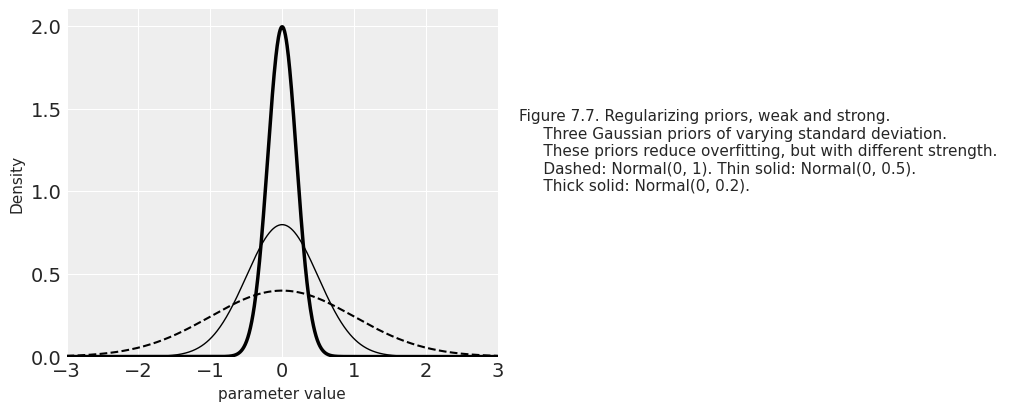

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Define x range
x = np.linspace(-3, 3, 1000)

# Define three Gaussian distributions
# Normal(0, 1) - Dashed line
normal_0_1 = stats.norm.pdf(x, loc=0, scale=1)

# Normal(0, 0.5) - Thin solid line
normal_0_05 = stats.norm.pdf(x, loc=0, scale=0.5)

# Normal(0, 0.2) - Thick solid line
normal_0_02 = stats.norm.pdf(x, loc=0, scale=0.2)

# Plot the distributions
ax.plot(x, normal_0_1, linestyle='--', color='black', linewidth=1.5, label='Normal(0, 1)')
ax.plot(x, normal_0_05, linestyle='-', color='black', linewidth=1, label='Normal(0, 0.5)')
ax.plot(x, normal_0_02, linestyle='-', color='black', linewidth=2.5, label='Normal(0, 0.2)')

# Set labels
ax.set_xlabel('parameter value', fontsize=11)
ax.set_ylabel('Density', fontsize=11)

# Set axis limits
ax.set_xlim(-3, 3)
ax.set_ylim(0, 2.1)

# Set y-axis ticks
ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add text annotation to the right of the plot
text_x = 3.3
text_y = 1.5

caption_text = (
    "Figure 7.7. Regularizing priors, weak and strong. \n \
    Three Gaussian priors of varying standard deviation. \n \
    These priors reduce overfitting, but with different strength. \n \
    Dashed: Normal(0, 1). Thin solid: Normal(0, 0.5). \n \
    Thick solid: Normal(0, 0.2)."
)

ax.text(text_x, text_y, caption_text, fontsize=11,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transData)

# Adjust layout to make room for text
plt.subplots_adjust(right=0.55)
plt.show()

To put regularization into practice, we typically assume our predictors are standardized and then apply a skeptical prior to the slope, such as $\beta \sim \text{Normal}(0, 1)$. On [Figure 7.7](#scrollTo=70hpIzTRNmmC), this prior is represented in the *dashed line* and what it tells us is that the model that it is highly skeptical of extreme values before seeing any data, thus assigning very little plausibility to any effect larger than two standard deviations. By concentrating probability mass around zero, these priors act as a conservative force, shrinking our parameter estimates toward zero and preventing the model from overreacting to every spike and dip in the training data.

The other lines in Figure 7.7 represent more conservative priors. The thin solid curve is a stronger Gaussian prior with a standard deviation of $0.5$ while the thick solid curve is an even stronger prior with a deviation of $0.2$.

In [ ]:
def sim_train_test_with_prior(N=20, k=3, rho=[0.15, -0.4], b_sigma=100, samples=1000):
    """
    Simulate train and test deviance for a linear regression model with specified prior.

    Parameters
    ----------
    N : int
        Sample size for both training and test datasets.
    k : int
        Number of parameters in the model (including intercept).
    rho : list of float
        Correlation coefficients between outcome and predictors.
    b_sigma : float
        Prior standard deviation for the regression coefficients.
    samples : int
        Number of MCMC samples to draw.

    Returns
    -------
    tuple of float
        (train_deviance, test_deviance)
    """

    # Determine the dimension of the data
    n_dim = max(k, 1 + len(rho))

    # Create correlation matrix
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:min(len(rho)+1, n_dim)] = rho[:min(len(rho), n_dim-1)]
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    # Generate training and test data
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    if N == 1:
        x_train = x_train.reshape(1, -1)
        x_test = x_test.reshape(1, -1)

    # Create design matrix for training
    mm_train = np.ones((N, 1))
    if k > 1:
        mm_train = np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

    # Fit Bayesian linear regression model
    with pm.Model() as m_sim:
        vec_V = pm.MvNormal(
            "vec_V",
            mu=0,
            cov=b_sigma * np.eye(k),
            shape=(1, k),
            initval=np.random.randn(1, k) * 0.01,
        )
        mu = pm.Deterministic("mu", pm.math.dot(mm_train, vec_V.T))
        y = pm.Normal("y", mu=mu, sigma=1, observed=x_train[:, 0].reshape(-1, 1))

    with m_sim:
        trace_m_sim = pm.sample(samples, progressbar=False)

    # Extract posterior means
    vec = az.summary(trace_m_sim)["mean"][:k].values
    vec = vec.reshape(k, -1)

    # Compute training deviance
    y_train_pred = np.matmul(mm_train, vec).flatten()
    dev_train = -2 * np.sum(stats.norm.logpdf(x_train[:, 0], loc=y_train_pred, scale=1))

    # Create design matrix for test
    mm_test = np.ones((N, 1))
    if k > 1:
        mm_test = np.concatenate([mm_test, x_test[:, 1:k]], axis=1)

    # Compute test deviance
    y_test_pred = np.matmul(mm_test, vec).flatten()
    dev_test = -2 * np.sum(stats.norm.logpdf(x_test[:, 0], loc=y_test_pred, scale=1))

    return dev_train, dev_test


def run_simulation_with_priors(n, prior_sigmas, tries=10, param=6):
    """
    Run simulations for different numbers of parameters and different prior strengths.

    Parameters
    ----------
    n : int
        Sample size
    prior_sigmas : list
        List of prior standard deviations to test
    tries : int
        Number of simulation runs
    param : int
        Maximum number of parameters

    Returns
    -------
    dict
        Dictionary with keys as prior sigmas, values as (num_param, train_means, test_means)
    """
    results = {}

    for sigma in prior_sigmas:
        print(f"\nN={n}, Prior sigma={sigma}")
        train_means = []
        test_means = []
        num_params = []

        for j in range(1, param + 1):
            print(f"  Num Params: {j}")
            train = []
            test = []

            for i in tqdm.tqdm(range(1, tries + 1), desc=f"  Runs"):
                # For k=1, we only have intercept
                if j == 1:
                    tr, te = sim_train_test_with_prior(N=n, k=1, b_sigma=sigma**2, samples=1000)
                else:
                    tr, te = sim_train_test_with_prior(N=n, k=j, b_sigma=sigma**2, samples=1000)
                train.append(tr)
                test.append(te)

            train_means.append(np.mean(train))
            test_means.append(np.mean(test))
            num_params.append(j)

        results[sigma] = (np.array(num_params), np.array(train_means), np.array(test_means))

    return results


def plot_regularization_comparison(ax, results, n):
    """
    Plot training and testing deviance for different prior strengths.

    Parameters
    ----------
    ax : matplotlib axis
        Axis to plot on
    results : dict
        Results from run_simulation_with_priors
    n : int
        Sample size for title
    """
    # Define line styles for different priors
    styles = {
        1.0: {'linestyle': '--', 'label': 'N(0,1)', 'linewidth': 1.5},
        0.5: {'linestyle': '-', 'label': 'N(0,0.5)', 'linewidth': 1},
        0.2: {'linestyle': '-', 'label': 'N(0,0.2)', 'linewidth': 2.5}
    }

    # Plot training data (blue) for each prior
    for sigma in [1.0, 0.5, 0.2]:
        num_params, train_means, test_means = results[sigma]
        ax.plot(num_params, train_means, color='C0',
                linestyle=styles[sigma]['linestyle'],
                linewidth=styles[sigma]['linewidth'],
                marker='o' if sigma == 0.2 else 'o',
                markersize=4 if sigma == 0.2 else 3,
                markerfacecolor='C0' if sigma == 0.2 else 'C0',
                markeredgecolor='C0')

    # Plot testing data (black) for each prior
    for sigma in [1.0, 0.5, 0.2]:
        num_params, train_means, test_means = results[sigma]
        ax.plot(num_params, test_means, color='black',
                linestyle=styles[sigma]['linestyle'],
                linewidth=styles[sigma]['linewidth'],
                marker='o' if sigma == 0.2 else 'o',
                markersize=4 if sigma == 0.2 else 3,
                markerfacecolor='none' if sigma == 0.2 else 'none',
                markeredgecolor='black')

    # Set labels and title
    ax.set_xlabel('number of parameters', fontsize=11)
    ax.set_ylabel('deviance', fontsize=11)
    ax.set_title(f'N = {n}', fontsize=12)
    ax.set_xticks([1, 2, 3, 4, 5])

    # Add legend for line styles
    legend_elements = [
        plt.Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, label='N(0,1)'),
        plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1, label='N(0,0.5)'),
        plt.Line2D([0], [0], color='black', linestyle='-', linewidth=2.5, label='N(0,0.2)')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=9, frameon=False)

In [ ]:
# Main execution
tries = 10
param = 5
prior_sigmas = [1.0, 0.5, 0.2]

# Setting log output to error
logger = logging.getLogger("pymc")
init_level = logger.level
logger.setLevel(logging.ERROR)

# Run simulations for N=20
print("Running simulations for N=20...")
results_20 = run_simulation_with_priors(n=20, prior_sigmas=prior_sigmas,
                                        tries=tries, param=param)

# Run simulations for N=100
print("\nRunning simulations for N=100...")
results_100 = run_simulation_with_priors(n=100, prior_sigmas=prior_sigmas,
                                        tries=tries, param=param)

# Reset logger level
logger.setLevel(init_level)

Running simulations for N=20...

N=20, Prior sigma=1.0
  Num Params: 1


  Runs: 100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


  Num Params: 2


  Runs: 100%|██████████| 10/10 [00:48<00:00,  4.81s/it]


  Num Params: 3


  Runs: 100%|██████████| 10/10 [00:50<00:00,  5.09s/it]


  Num Params: 4


  Runs: 100%|██████████| 10/10 [01:03<00:00,  6.30s/it]


  Num Params: 5


  Runs: 100%|██████████| 10/10 [00:56<00:00,  5.67s/it]



N=20, Prior sigma=0.5
  Num Params: 1


  Runs: 100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


  Num Params: 2


  Runs: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it]


  Num Params: 3


  Runs: 100%|██████████| 10/10 [00:42<00:00,  4.28s/it]


  Num Params: 4


  Runs: 100%|██████████| 10/10 [00:51<00:00,  5.11s/it]


  Num Params: 5


  Runs: 100%|██████████| 10/10 [00:47<00:00,  4.77s/it]



N=20, Prior sigma=0.2
  Num Params: 1


  Runs: 100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


  Num Params: 2


  Runs: 100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


  Num Params: 3


  Runs: 100%|██████████| 10/10 [00:38<00:00,  3.85s/it]


  Num Params: 4


  Runs: 100%|██████████| 10/10 [01:00<00:00,  6.03s/it]


  Num Params: 5


  Runs: 100%|██████████| 10/10 [00:48<00:00,  4.82s/it]



Running simulations for N=100...

N=100, Prior sigma=1.0
  Num Params: 1


  Runs: 100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


  Num Params: 2


  Runs: 100%|██████████| 10/10 [00:42<00:00,  4.27s/it]


  Num Params: 3


  Runs: 100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


  Num Params: 4


  Runs: 100%|██████████| 10/10 [00:46<00:00,  4.65s/it]


  Num Params: 5


  Runs: 100%|██████████| 10/10 [00:49<00:00,  4.91s/it]



N=100, Prior sigma=0.5
  Num Params: 1


  Runs: 100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


  Num Params: 2


  Runs: 100%|██████████| 10/10 [00:42<00:00,  4.26s/it]


  Num Params: 3


  Runs: 100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


  Num Params: 4


  Runs: 100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


  Num Params: 5


  Runs: 100%|██████████| 10/10 [00:49<00:00,  4.94s/it]



N=100, Prior sigma=0.2
  Num Params: 1


  Runs: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


  Num Params: 2


  Runs: 100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


  Num Params: 3


  Runs: 100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


  Num Params: 4


  Runs: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


  Num Params: 5


  Runs: 100%|██████████| 10/10 [00:55<00:00,  5.55s/it]


### Figure 7.8. Regularizing priors and out-of-sample deviance.

/tmp/ipython-input-3463512430.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


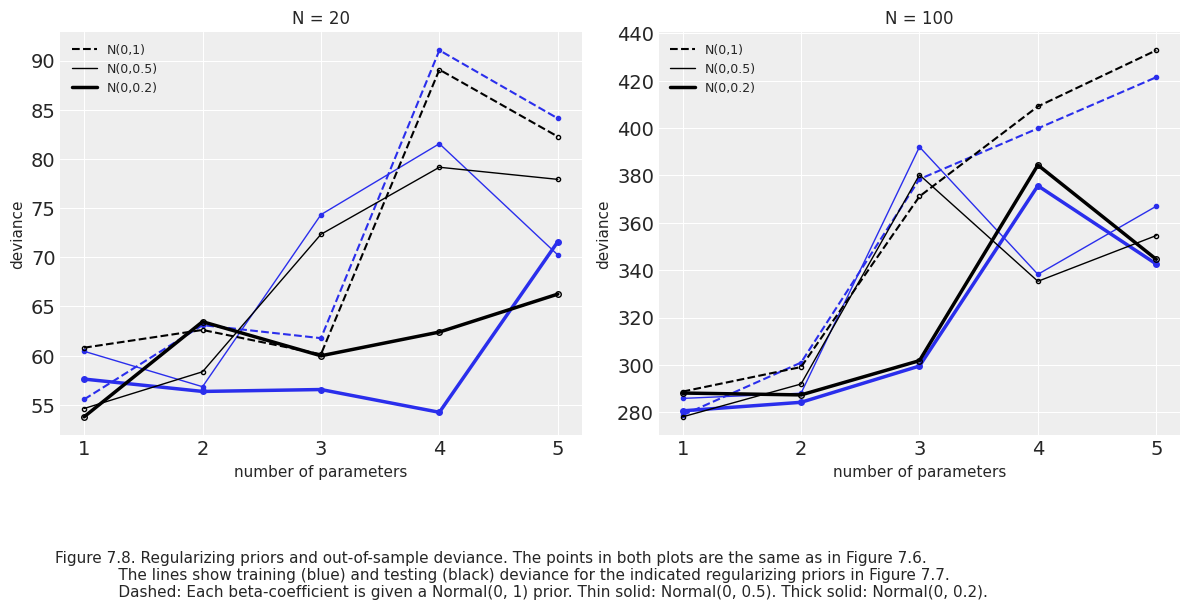

In [ ]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot both
plot_regularization_comparison(ax1, results_20, 20)
plot_regularization_comparison(ax2, results_100, 100)

# Add caption below the figure
caption = ("Figure 7.8. Regularizing priors and out-of-sample deviance. The points in both plots are the same as in Figure 7.6. \n \
            The lines show training (blue) and testing (black) deviance for the indicated regularizing priors in Figure 7.7.\n \
            Dashed: Each beta-coefficient is given a Normal(0, 1) prior. Thin solid: Normal(0, 0.5). Thick solid: Normal(0, 0.2).")

fig.text(0.05, -0.2, caption, ha='left', fontsize=11, wrap=True)

plt.tight_layout()
plt.show()

Through thousands of simulations, we can see exactly how this skepticism in [Figure 7.7](#scrollTo=70hpIzTRNmmC) pays off. In [Figure 7.8](#scrollTo=2M3FLVxVNy5Q), we'll repeat the train-test example we used in [Figure 7.6](#scrollTo=erHh2F4f-dXh), along with the three regularized priors in Figure 7.7, to show that in small samples, a tight prior intentionally makes the training deviance worse because it prevents the model from adapting perfectly to that specific sample. To further contextualize, the blue lines display the results for the training data while the black line represents the deviance in the test data. The different line styles show the results for the three regularizing priors we're testing.

If we look at the left-hand plot where $N = 20$, we'll notice that the defviance always increases (i.e. the predictive accuracy gets worse) as the priors get tighter. However, this is a trade-off worth making because as we see with the test data - the out-of-sample deviance actually improves, especially in overly complex models. By using a very skeptical prior, we can essentially "neutralize" the harm of adding too many parameters, as the prior prevents the model from chasing the noise those extra variables provide.

As the sample size increases to $N = 100$ in the right-hand plot, the influence of these priors naturally fades because the overwhelming evidence in the data eventually overpowers our initial skepticisml, regardless of how tight our priors were initially. This demonstrates the beauty of regularizing priors which is that they provide essential protection when data is scarce without permanently blinding the model to strong patterns when data is abundant. However if they are too skeptical, they prevent the model from learning from that data. Ultimately, the goal is to find the right level of skepticism to reduce overfitting without causing underfitting, a balance that leads directly to the more advanced "adaptive" regularization we see in multilevel models.

**Rethinking: Ridge Regression.** It is worth noting that linear models utilizing Gaussian priors centered at zero are often referred to in non-Bayesian contexts as **Ridge Regression**. In this framework, the narrowness of the prior is controlled by a precision parameter, $\lambda$. Just like the Bayesian approach, choosing a $\lambda > 0$ serves to reduce overfitting by penalizing large coefficients. However, the risk remains that if $\lambda$ is set too high, the model may become overly biased and result in underfitting.

While Ridge Regression was not originally developed as a Bayesian method, it represents a fascinating bridge between two statistical worlds. Instead of calculating a full posterior distribution, it employs a modified version of Ordinary Least Squares (OLS) that incorporates $\lambda$ directly into the matrix algebra used to estimate parameters. Although tools like the `lm.ridge` function make this regularization easy to implement, it is a curious fact of history that most traditional statistical methods continue to operate without any regularization at all, leaving them vulnerable to the "excitement" of the training sample.

## ***Section 7.4* - Predicting predictive accuracy**

Everything we have discussed so far points toward a single, vital goal: we must evaluate our models based on their performance out-of-sample. However, we are immediately faced with a practical paradox—by definition where we do not yet have access to the "out-of-sample" data we wish to predict. So how can we possibly measure a model's accuracy on data that doesn't exist?

To solve this predicament, we rely on two primary families of strategies: cross-validation and information criteria. These methods are designed to intelligently "guess" or estimate how well a model will perform, on average, when it is eventually confronted with new data. While the underlying mathematics of these two approaches differ in subtle ways, they are essentially trying to answer the same question and often produce remarkably similar approximations of a model's true predictive power.

### **7.4.1. Cross-validation.**

A popular strategy for estimating predictive accuracy is to actually test the model’s performance on a small part of the sample. This is known as **cross-validation** where we leave out a small chunk of observations, train the model on the rest, and then evaluate how well it predicts those "missing" pieces.

Since we don't want to waste data, we typically divide the sample into several chunks called "folds," asking the model to predict each fold after training on all the others, and then averaging the scores. While the minimum number of folds you can test on is $2$, an extremely common process is called **leave-one-out cross-validation (LOOCV)** which uses the maximum possible number where *each individual observation becomes its own fold*.

However, the primary trouble with LOOCV is that if you have 1000 observations, you theoretically have to compute 1000 separate posterior distributions, which is incredibly time-consuming and compute intensive. Luckily there's a clever shortcut called **Pareto-smoothed importance sampling (PSIS)** which estimates the importance of each observation. By "importance," what we mean here is that some data points have a much larger impact on the posterior than others and we can observe this by observing how much it affects the poster if it were to be removed.

The key intuition here is that an observation that is relatively unlikely, and therefore may violate our model's expectations, is more "important" because it changes our expectation and thus results in an updated posterior belief. We can characterize the "importance" of these observations as **weights** which can be used to estimate our model's out-of-sample accruacy. Additionally, these weights can approximate the cross-validation score without ever actually refitting the model.

By smuggling some complex mathematical details under the carpet, all we need to know is that **Pareto-smoothing** uses "importance sampling," which again refers the importance weights approach, to make those weights more reliable by drawing on the Pareto distribution which we'll cover in more detail in the *Overthinking* section below.

Perhaps the best feature of PSIS is that it is "self-aware" by providing feedback about its own reliability through flagging specific observations with very high weights that might make the PSIS score inaccurate. This allows us to gain the benefits of cross-validation with a fraction of the computational cost while remaining alert to potential errors in the estimate.

### **Overthinking: Pareto-smoothed cross-validation.**

In theory, we calculate the out-of-sample accuracy by performing the "leave-one-out" procedure for every single data point in our set. If we have $N$ observations, we fit the model $N$ times, each time dropping a single observation $y_i$. The total out-of-sample **log-pointwise-predictive-density ($\text{lppd}_{cv}$)** is then calculated by summing the log-average accuracy of each omitted observation, using only the posterior distributions that were trained without that specific point. Mathematically, the cross-validation score is expressed as:

$\text{lppd}_{cv} = \sum_{i=1}^{N} \log \left( \frac{1}{S} \sum_{s=1}^{S} Pr(y_i | \Theta_{-i, s}) \right) $

In this equation, $s$ indexes the samples drawn from our posterior distribution, and $\Theta_{-i, s}$ represents the $s$-th set of parameter values sampled from a model that was trained on all data points except for observation $i$.

While this provides a direct measure of how well the model generalizes to "new" data, the formula highlights why this is so computationally expensive because it requires a unique posterior distribution for every individual observation in your sample.

Importance sampling allows us to bypass the grueling task of computing $N$ separate posterior distributions by using a clever re-weighting trick. Instead of refitting the model every time we drop an observation, we can take samples from the "full" posterior (the one trained on all the data), $p ( y_i | \Theta_s )$, and adjust them so they look like samples from a "leave-one-out" posterior. To do this, we calculate the "importance" of each sample $s$ for a given omitted observation $y_i$.The trick relies on an **importance weight**, $r(\Theta_s)$, which is defined as the inverse of the probability of the omitted observation:

$ r ( \Theta_s ) = \frac{1}{p ( y_i | \Theta_s )} $

Essentially, if an observation $y_i$ is very unlikely according to a particular set of parameters $\Theta_s$, that observation has a high "importance" or "leverage." By weighting our existing samples by these values, we can effectively simulate what the posterior would have looked like if that data point had never been there in the first place, saving us from the massive computational burden of running the model over and over again.

This weight is only relative but is normalized inside the mathematical expression intuitively represented as "the log of the **weighted** average probability:"

$ \text{lppd}_{IS} = \sum_{i=1}^{N} \log \frac{\sum_{i=1}^{s} r (\Theta_s ) p (y_i | \Theta_s )}{\sum_{i=1}^{S} r (\Theta_s )} $

*Where:*

 - $r(\Theta_s)$ (The Importance Weight): This is the most critical part. It is a "weight" assigned to each sample in your posterior. If a sample is very likely in the "leave-one-out" world but unlikely in the "full" world, $r$ will be large. It basically tells the formula: "Pay more attention to this sample."
 - $p(y_i | \Theta_s)$ (The Likelihood): This is the standard probability of seeing data point $i$ given a specific parameter set.
 - **The Fraction** ($\frac{\text{Numerator}}{\text{Denominator}}$): This is a weighted average. Instead of dividing by $S$ (the total number of samples), we divide by the sum of the weights.
 - $\sum \log$: Just like the standard LPPD, we take the log of the average for each point and sum them up to get the total score.

There's also a <u>simpler version</u> if we aren't doing advanced importance sampling (PSIS) that doesn't worry about weighting points or leaving some out and assumes that every sample in your MCMC trace is an equally valid representative of the posterior. This equation can be intuitively understood as "the log of the average probability:"

$\text{lppd}_{IS} = \sum_{i=1}^{N} \log \left( \frac{1}{S} \sum_{s=1}^{S} p(y_i | \Theta_s) \right)$

While importance sampling is powerful, the raw weights $r(\Theta_s)$ we calculate can be dangerously unreliable. If a single weight becomes too large, it can dominate the entire calculation and ruin our estimate of predictive accuracy. Rather than simply truncating these weights and introducing unwanted bias, we use Pareto smoothing to stabilize them. This technique relies on the fact that the largest weights in a distribution should follow a specific mathematical shape known as the generalized **Pareto Distribution**:

$ p ( r | u , \sigma , k) = \sigma^{-1} (1 + k (r - \mu)\sigma^{-1} )^{- \frac{1}{k} - 1} $

Where:
- $u$ is the location parameter;
- $\mu$ is the scale;
- $k$ is the shape

By fitting the largest weights for each observation $y_i$ to this distribution, we can "smooth" them out using that same distribution to make the final estimate much more robust. However, the most valuable part of this process is arguably that it provides an internal diagnostic tool via shape parameter, $k$, which provides information about the reliability of the approximation. Each data point gets its own $k$ value, which acts as a measure of that point's influence. If $k > 0.5$, the variance becomes infinite, indicating a "thick tail" that makes the weights harder to trust. Still, research suggests that PSIS' weights preform well as long as $k$ stays below $0.7$. When we use this method in practice, these $k$ values serve as essential warnings that flag influential observations that might be distorting our model's world view.

### **7.4.2. Information criteria.**

The second major strategy for estimating predictive accuracy is the use of information criteria. These tools are designed to construct a theoretical estimate of the out-of-sample **Kullback–Leibler (K-L) Divergence**.

If you look closely back again [Figure 7.8](#scrollTo=2M3FLVxVNy5Q) for example, a curious pattern emerges: *For simple linear models with flat priors, the gap between training deviance and testing deviance is almost exactly twice the number of parameters in the model*.

This is one of the most remarkable results in machine learning because it suggests that the "overfitting penalty" is directly proportional to a model's complexity. This phenomenon is the foundation of the **Akaike Information Criterion (AIC)**, which estimates the average out-of-sample deviance using a deceptively simple formula:

$AIC = D_{train} + 2p = -2\text{lppd} + 2p$

In this equation, $p$ represents the number of free parameters in the posterior distribution. AIC tells us that the dimensionality of the posterior distribution is a natural measure of a model's tendency to overfit. While groundbreaking, AIC is now mostly of historical interest because it only works reliably under strict conditions:

1. The priors must be flat;
2. The posterior must be Gaussian;
3. And the sample size must be much larger than the number of parameters.

Because flat priors are hardly ever the best priors, we need more flexible tools that are generalizable. While the Deviance Information Criterion (DIC) was a step toward handling informative priors, we will focus on the **Widely Applicable Information Criterion (WAIC)** which is far more powerful because it makes no assumptions about the shape of the posterior distribution. It provides an approximation of out-of-sample deviance by aiming for the out-of-sample K-L Divergence directly.

While WAIC and cross-validation often produce very similar results in large samples, they are theoretically distinct tools that give us two different, but equally valuable, ways to peek at how our models will handle the future. They can also disagree when working with more limited datasets because WAIC isn't trying to approximate the cross-validation score but rather, guess the out-of-sample K-L Divergence.

Unfortunately, computing the WAIC comes at the expense of a more complicated formula. However, we can think of it as a <u>method for model selection</u> to select the model with the best ability to generalize and predict unseen data by balancing the model's complexity with it's preformance on the training data (**[lppd](#scrollTo=uvfO2y01kwiH)**). A simplified version of the WAIC formula below is: `WAIC = -2 * (Fit - Complexity)`.

$ \text{WAIC}( y, \Theta ) = 2 ( \space \text{lppd} - \underbrace{\sum_{i} \text{var}_{\theta} \log p ( y_i | \Theta ) \space )}_{\text{penalty term}}$

In the formula above, $y$ is the observations and $\Theta$ represents the posterior distribution. In simple English, the penalty term means: "*measure the complexity of the model by computing the variance in log-probabilities (i.e. the predictions) for each observation $i$ and then sum up these variances to get the total penalty.*"

Historically, this penalty is often called the "effective number of parameters" ($p_{WAIC}$), but that label can be misleading. In modern modeling, especially multilevel models, the relationship between parameters is what matters most so therefore adding a parameter can sometimes actually *reduce* the "**effective number of parameters**" (a term that is sometimes used interchangeably with WAIC). We can also call it the total overfitting risk.

Because WAIC is "pointwise," meaning that predictions are considered 'case-by-case' or 'point-by-point' in the data, it offers several practical advantages. First, it acknowledges that some observations are simply harder to predict or involve more uncertainty than others. Second, because it handles the data as a collection of independent points, we can use the central limit theorem to calculate a standard error for our WAIC estimate for each observation:


$ s_{WAIC} = \sqrt{N \text{var} - 2 ( \text{lppd}_i - p_i ) } $

In the equation above, $N$ represents the number of observations while $p_i$ is the penalty term for observation $i$. In summary, WAIC gives us a measure of how much uncertainty exists in our estimate of the model's future performance.

However, this pointwise nature also reveals a limitation about WAIC in that it assumes that observations are independent and "exchangeable" with one another. In cases like time series, where today’s data depends on yesterday’s, defining an "independent observation" becomes difficult, and the meaning of WAIC becomes less clear.

Ultimately, the validity of any tool used to guess unseen data depends entirely on the specific predictive task you are trying to solve.

### **Rethinking: Information criteria and consistency.**

It is often surprising to discover that information criteria like AIC and WAIC do not always point to the "true" model that generated the data. In statistical terms, these criteria are not **consistent**, meaning they aren't designed to identify the exact structure of reality. However, this doesn't mean they are broken; it simply means their target is different. Their goal is to nominate the model that will produce the best possible predictions, and in the messy world of science, being "true" and being "predictive" are not always the same thing.

Concerns about consistency are usually based on **asymptotic** logic where we imagine what happens as our sample size  approaches infinity. In this infinite-data limit, criteria like WAIC and cross-validation tend to favor the most complex model available and are sometimes accused of "overfitting" by critics.

However with infinite data, an overly complex model is harmless to the model's predictive accuracy because every parameter can be precisely estimated with this much data. If you have enough data to estimate every parameter with perfect precision, the likelihood becomes so sharp that the posterior distribution for every parameter (even the "extra" ones) collapses around its true value. If the "true" effect of a variable is zero, a model with infinite data will estimate that coefficient as exactly zero with zero uncertainty. Additionally, the complex model essentially "simplifies itself" at the limit and its predictions become identical to the simpler, true model.

In the real world and especially with the natural and social sciences, the models we consider are almost never the actual data-generating processes anyway. Since we are usually choosing between different approximations of a complex reality, it makes little sense to obsess over identifying a "true" model that doesn't exist in our set. Instead, we should focus on what these criteria are actually good at which is finding the model that best balances complexity and evidence to navigate the future.

### **Rethinking: What about BIC and Bayes Factor.**

While we often see the **Bayesian Information Criterion (BIC)**, also known as Schwarz Criterion, is commonly juxtaposed with AIC. However, the choice between them isn't actually about whether you are a "Bayesian" or not. In fact, both can be motivated through either Bayesian or non-Bayesian logic. The BIC is closely related to the **Bayes factor** which compares models by looking at their "average likelihood" of a linear model which describes the likelihood of the data averaged over the entire prior distribution (i.e. the denomenator in Bayes' Theorem). Because this average likelihood naturally penalizes models that spread their prior probability too thinly over many parameters, it provides a built-in defense against overfitting.

However, many Bayesian practitioners are wary of Bayes' factors for two major reasons. First, the average likelihood is notoriously difficult to calculate. Even if you have a perfect posterior distribution, the math required to find the denominator of Bayes’ theorem can be a nightmare and you may not be able to estimate the average likelihood. Second, Bayes factors are incredibly sensitive to the choice of priors. Even "weak" priors that have no visible effect on a single model’s results can radically shift the comparison between two different models.

Ultimately, there is no need to pick a side. We can use both information criteria and Bayes factors to see where they agree and where they clash. The most important thing to remember is that both are purely predictive tools. They are designed to find patterns that help forecast the future but they are entirely blind to causation. They will happily nominate a model full of confounded variables if those variables happen to improve its "score," reminding us that a good prediction is not the same thing as a true explanation.


### **Overthinking: WAIC Calculations.**


#### Code 7.19

7.19 to 7.25 transcribed directly from 6.15-6.20 in [Chapter 6 of 1st Edition](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb).

To see how WAIC calculations work, consider a simple regression model:

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/vanislekahuna/Statistical-Rethinking-PyMC/refs/heads/main/Data/cars.csv", sep=",", index_col=0)
print(data.shape)
data.head()

(50, 2)


,speed,dist
1,4,2
2,4,10
3,7,4
4,7,22
5,8,16


In [ ]:
with pm.Model() as m:
    a = pm.Normal("a", mu=0, sigma=100)
    b = pm.Normal("b", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", 0, 30)
    mu = pm.Deterministic("mu", a + b * data["speed"].values)
    dist = pm.Normal("dist", mu=mu, sigma=sigma, observed=data["dist"].values)
    m = pm.sample(5000, tune=10000)

post = az.extract_dataset(m.posterior)
post = post.sel(draw=slice(None, None, int(len(post.sample) / 1000)))

Output()

/tmp/ipython-input-1693198948.py:9: FutureWarning: extract_dataset has been deprecated, please use extract
  post = az.extract_dataset(m.posterior)


#### Code 7.20

From the code box below, we'll calculate the log-likelihood of each observation $i$ at each sample $s$ from the posterior and store it in a matrix. Essentially, what we're asking is: "For every individual person/case in my data, how likely is their actual outcome according to every single specific combination of parameters my model found?"

With the code below, we're essentially creating a $50$ by $1,000$ container for every row $(50)$ in our `data` dataset and a column for every posterior sample $(1,000)$ in our `logprob` object.

#### **A Quick Review of the Posterior Distribution Object that's Sampled from our PyMC Model.**

Before we get into the specifics of the code and the samples we're drawing from it, let's do a quick review with [Gemini](https://gemini.google.com/apphttps://gemini.google.com/app) of the data that's stored inside the `post` object representing the posterior distribution of the model.

In PyMC (and the broader ArviZ ecosystem), the `post` object—typically an `InferenceData` object or an extracted `Dataset`—is essentially a multi-dimensional array with metadata. To understand how it stores everything, it helps to think of it as a **labeled, multi-layered grid.**

### 1. The Core Dimensions

The posterior isn't just a list; it is structured by the process that created it. By default, it has two primary dimensions:

* **Chains:** If you ran 4 parallel "walkers" to explore the parameter space, this dimension represents which walker created the data.
* **Draws:** This is the sequence of steps (samples) each walker took (e.g., 0 to 4999).

When you use `az.extract_dataset(m.posterior)`, ArviZ often flattens these into a single dimension called **`sample`** (Chain × Draw). In your code, `n_samples = 1000` refers to this flattened dimension.

### 2. How it stores different parameters

Instead of being a single table, the `post` object acts like a **dictionary of arrays**. Each parameter you defined in your model (`a`, `b`, `sigma`, and even the deterministic `mu`) becomes a "variable" inside this object.

Each variable "lives" on the `sample` dimension:

* `post["a"]`: A vector of 1,000 values (one intercept for every sample).
* `post["b"]`: A vector of 1,000 values (one slope for every sample).
* `post["sigma"]`: A vector of 1,000 values (one noise estimate for every sample).

### 3. The "Broadcasting" Magic

The reason the `post` object is so powerful for the loop you asked about is how it handles dimensions.

When you look at line 19 of your code:
`mu = post["a"][s].values + post["b"][s].values * data["speed"].values`

* `post["a"][s]` is a **scalar** (a single number).
* `post["b"][s]` is a **scalar** (a single number).
* `data["speed"].values` is a **vector** (e.g., 50 different car speeds).

Because of how Python (NumPy) works, the model takes that one "theory" (one  and one ) and **broadcasts** it across all 50 car speeds simultaneously. This creates a vector of 50 `mu` values.

### Summary of the Structure

If you were to visualize the `post` object for your 1,000 samples, it looks like this:

| Sample Index | `a` (Intercept) | `b` (Slope) | `sigma` (Noise) |
| --- | --- | --- | --- |
| 0 | -33.74070484 | 4.94312276 | 2.1 |
| 1 | -12.61357479 | 3.712494 | 2.0 |
| ... | ... | ... | ... |
| 999 | -21.52117524 | 4.1886732 | 2.2 |

The object keeps these distributions aligned so that when you pull the $N^{th}$ index, you are getting a **coherent snapshot** of the model. You aren't just getting a random  and a random ; you are getting the specific  and  that the Markov chain "stood on" at that exact moment in the simulation.

---

Then, with the `p_` object, the code is comparing the observed data (`data["dist"]`) against a Normal distribution. In each of the thousand iterations, the code defines the "likelihood" of the data by using a unique mean ($\mu$) and standard deviation ($\sigma$) pulled from that iteration of the posterior sample. Unlike with Frequentist Statistics, the "prediction" here isn't just one value but the entire Normal distribution defined by those parameters. If an actual data point falls near the peak of that distribution, the code assigns it a small negative number (high probability) through a log-probability calculation. If the point falls far out into the tails, it receives a large negative number (low probability).

The last piece of the loop (i.e. `logprob[:, s] = p_`) saves that vertical column of log-probabilities into the $s$-th column of the `logprob` matrix. Once the loop finishes, you have a complete map of "goodness-of-fit." You can look at a single row to see how well different samples explained a specific person, or look at a single column to see how well one specific version of your model explained the entire group. From this matrix, you can easily calculate the LPPD by averaging across the columns for each row.

In [ ]:
n_samples = 1000
n_cases = data.shape[0]
logprob = np.zeros((n_cases, n_samples))
print(f"Dimensions of the 'logprob' container: {logprob.shape}")

for s in range(0, n_samples):
    mu = post["a"][s].values + post["b"][s].values * data["speed"].values
    p_ = stats.norm.logpdf(data["dist"], loc=mu, scale=post["sigma"][s])
    logprob[:, s] = p_

Dimensions of the 'logprob' container: (50, 1000)


#### Code 7.21

The code below prepares a vector called `lppd` with one slot for every case (person) in the dataset. This will hold the final "average accuracy" for each of the individuals in it by:
1. Undoing the logarithms (exponentiate them back into raw probabilities);
2. Taking the average;
3. Re-loging the result.

In a nutshell, the `logsumexp` function does the process of **Exponentiate** $\rightarrow$ **Sum** $\rightarrow$ **Log** automatically and subtracting it with `np.log(n_samples)` which is the log of $1,000$.

`np.log(1000) = 6.907755278982137`

Once this loop finishes, `lppd` contains a single value for each person representing the **log of the average probability** that the model assigned to that person’s actual observed outcome.

And if you were to sum all these values together (`sum(lppd)`), you would have the total LPPD for the model. As the Prof McElreath would put it, this is the "total log-plausibility" of the data, given the model. It is the gold standard for measuring how well the model has learned the patterns in your sample, and it serves as the foundation for the information criteria (like WAIC) discussed earlier.

In [ ]:
n_cases = data.shape[0]
lppd = np.zeros(n_cases)
for a in range(1, n_cases):
    lppd[a] = logsumexp(logprob[a]) - np.log(n_samples)

#### Code 7.22

This block of cosde is similar to `7.21` except that it's calculating the variance for each value in the $1,000$ log-probabilities stored in the `logprob` object.

Computing this variance is a clever way to measure risk or the overfitting cost. If the $1,000$ different "theories" in your posterior all agree on a data point, the variance is low. But if the theories disagree wildly—meaning some samples think the data point is very likely and others think it’s impossible—the variance is high. This high variance signals that the model is "struggling" or getting overexcited by that specific observation, which increases the risk of overfitting.

In [ ]:
pWAIC = np.zeros(n_cases)
for i in range(1, n_cases):
    pWAIC[i] = np.var(logprob[i])

#### Code 7.23

Finally, the code puts everything together using the standard formula. It takes the total accuracy (the sum of `lppd`) and subtracts the total overfitting penalty (the sum of `pWAIC`).

The result is then multiplied by $-2$. This multiplication is a historical carryover from the original deviance formulas. In the world of information criteria, a "better" model is one with a smaller (more negative) WAIC. By multiplying by $-2$, we ensure that models with high accuracy and low complexity result in the lowest scores.

In [ ]:
-2 * (sum(lppd) - sum(pWAIC))

np.float64(412.49208517703187)

#### Code 7.24

In [ ]:
waic_vec = -2 * (lppd - pWAIC)
(n_cases * np.var(waic_vec)) ** 0.5

np.float64(15.056525261947836)

### **7.4.3. Comparing CV, PSIS, and WAIC.**

With definitions of cross-validation, PSIS, and WAIC in hand, we can now visualize how these criteria actually perform in guessing the future. The goal of any such criterion is to estimate **Out-of-Sample Deviance** (often called **Test Deviance**), which is the "**Average Error**" a model would make when predicting data it hasn't seen before. By comparing this to the **In-Sample Deviance** (the model's error on the data it was trained on), we can see the "overfitting gap." [Figure 7.9](#scrollTo=DUF-cNfVUnVy) illustrates this across 1,000 simulations, testing how well our mathematical shortcuts can predict that gap.

In the top-left plot (where the sample size $N = 20$), we see a clear distinction between models using flat priors (the open points) and those using regularizing priors (the filled points). The regularizing priors consistently result in lower out-of-sample deviance, meaning they are better at predicting new data. Our main interest, however, is in the trend lines representing *WAIC (black), full cross-validation (solid blue), and PSIS (dashed blue).*

All three criteria do a remarkably good job of tracking the actual average out-of-sample scores. This confirms a vital truth: Provided the process generating the data remains the same, it is truly possible to use a single sample to accurately guess the accuracy of our future predictions.

While these criteria get the "average" right over many simulations, we must also consider how much they miss the mark in any single, specific sample. The upper-right plot shows this "**Average Error**" which is the absolute difference between the estimated deviance and the true out-of-sample deviance. In these small samples, WAIC is slightly more accurate on average. This makes sense because WAIC is specifically designed to guess the out-of-sample **Kullback–Leibler (K-L) Divergence**, whereas cross-validation is a "trick" that only perfectly converges to that target as the sample size grows. When we move to the bottom row ($N = 100$), the differences vanish and with enough data, all three criteria become effectively identical.

In the context of these simple linear models, PSIS and WAIC perform very similarly. While WAIC is technically a more precise estimator of the K-L Divergence, the practical difference is often smaller than the overall expected error. If our only goal is to rank models from best to worst, both criteria are equally capable. However, PSIS offers a distinct advantage: it provides the $k$ values as a warning system. These diagnostics tell us exactly when the approximation might be failing and which specific data points are causing the trouble. In the end, we don't just want a score; we want to know when we can trust that score.

### Figure 7.9. WAIC and cross-validation as estimates of out-of-sample deviance.

<img src="https://raw.githubusercontent.com/vanislekahuna/Statistical-Rethinking-PyMC/refs/heads/main/Bayes-Textbook-Images/Fig7.9_WAIC_and_CrossValidation.png" width=500 height=600>

[Source](https://github.com/vanislekahuna/Statistical-Rethinking-PyMC/blob/main/Bayes-Textbook-Images/Fig7.9_WAIC_and_CrossValidation.png)

### **Rethinking: Diverse prediction frameworks.**

The "train-test" logic we have used throughout this chapter assumes we are predicting a future sample that is identical in nature and size to our current one. This is a helpful starting point, but it doesn't mean these tools are restricted to those specific conditions. We don't need the "true" data-generating model to be among our candidates for these criteria to be useful; we only need to compare the relative distances between models to identify which one predicts better. However, it is important to realize that this "train-test" thought experiment is just one way to evaluate a model, and it isn't always representative of the real-world tasks we face.

A much larger concern is the "uniformitarian" assumption which is the belief that future data will come from the exact same process and range of values as our past data. If this assumption fails, our information criteria cannot save us. Imagine fitting a model to the relationship between height and weight in a town within a 3rd world country where everyone is quite thin. If you then try to use that model to predict the heights of people in a much wealthier, heavier town in a 1st world country, your model will fail spectacularly. It will predict giant, impossible heights because it doesn't "know" that the relationship between weight and height changes once weight reaches a certain point.

WAIC, cross-validation, and PSIS are blind to these kinds of shifts in the underlying environment. They can tell you how well a model generalizes within the same world it was born in, but they cannot tell you if the world itself is about to change. No automated statistical procedure can solve this problem for you. Overcoming these limitations requires repeated rounds of model fitting, prediction, and—most importantly—rigorous scientific criticism. Ultimately, statistics is a powerful tool for navigating the data we have, but it is no substitute for a deep, scientific understanding of the process we are trying to study.


## ***Section 7.5* - Model Comparison**

We have reached a critical point in our journey. When faced with several plausible models, we know that simply following the "best fit" to our current data is a trap as it will always lead us toward overly complex models that fail in the future. We’ve established that information divergence is our true North Star for accuracy, but even that requires us to look at data the model hasn't seen yet. To solve this, we’ve developed two complementary strategies:

A) Regularizing priors which proactively curb overfitting by being skeptical of extreme values; and

B) Predictive criteria like CV, PSIS, and WAIC, which allow us to measure exactly how much overfitting is occurring.

The hardest part of this journey is the conceptual foundation we’ve just built. Actually using these tools in code is deceptively easy, which makes them dangerous if you don't understand what they are doing. A very common mistake is to use these criteria for **model selection** which is simply picking the model with the lowest WAIC score and throwing the rest away. However, you should never do this. By discarding the other models, you lose the vital information contained in the differences between their scores. Just as the width of a posterior distribution tells us how confident we should be about a parameter, the relative differences in WAIC scores tell us how confident we should be about our models.

Furthermore, we must never let these criteria be the sole arbiters of our analysis because maximizing predictive accuracy is not the same thing as inferring causation. A model can be a "**causal salad**," which is a term we've used in the past to describe a messy mix of confounded variables, and still make excellent short-term predictions. Such a model might help you forecast what will happen if things stay the same, but it will fail to tell you what would happen if you actually intervened in the system. We must be clear about our goals and statistics is no substitute for a coherent causal model.

Instead of model selection, we will focus on **model comparison** which is an approach that emphasizes using multiple models to understand how different variables influence our predictions and, when combined with causal logic, helps us identify the relationships that actually matter. We are not just looking for a winner; we are using these tools to measure the overfitting tendency of our models and to tune them more effectively. In the examples that follow, we will distinguish between models that predict well and models that explain well, while also learning how to inspect individual data points to reveal exactly where our models are missing the mark.

### **7.5.1. Model mis-selection.**

We must remain vigilant about a lesson we’ve encountered before: Inferring a cause and making a prediction are two entirely different tasks. Cross-validation and WAIC are specialized tools designed to find models that make good predictions, but they do absolutely nothing to solve the problem of causal inference. In fact, if you select a model based solely on its predictive accuracy, you are almost inviting confounding variables into your analysis. This happens because "backdoor paths," statistical associations that don't represent a direct cause, still provide valid information about the data. As long as you don't intervene in the system and the future remains like the past, these confounded models will forecast quite well.

However, our definition of knowing a cause is being able to predict the consequences of an intervention. A high score in PSIS or WAIC is no guarantee that you have a good causal model. Consider the plant growth example in the last chapter where we looked at the effect of a treatment on fungus, which then affected growth. If we compare a model that includes the fungus (`m_6_7`) against one that omits it (`m_6_8`), the model with the fungus will almost certainly have a better WAIC score. It makes better predictions because knowing whether a plant has fungus tells you a lot about its height.

But as we learned, the model that includes the fungus is causally "broken" because it masks the very treatment effect we are trying to study. To correctly infer the causal influence of the treatment, we must use the model that omits the fungus, even though it has a "worse" predictive score. A good score tells you that a model is a good tool for forecasting, but it doesn't tell you that the model understands how the world actually works. We cannot simply toss variables into a "causal salad" and expect WAIC to pick out the healthy ingredients for us.

#### Code 7.25

#### Setup for Code 7.25+

Have to reproduce m6.6-m6.8 from Code 6.13-6.17 in Chapter 6

In [ ]:
# number of plants
N = 100

# simulate initial heights
h0 = np.random.normal(10, 2, N)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)

# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

In [ ]:
with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = pm.Deterministic("mu", p * d.h0.values)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_6_trace = pm.sample(return_inferencedata=True)

Output()

In [ ]:
with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment.values + bf * d.fungus.values

    mu = pm.Deterministic("mu", p * d.h0.values)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_7_trace = pm.sample(return_inferencedata=True)

Output()

In [ ]:
with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment.values

    mu = pm.Deterministic("mu", p * d.h0.values)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_8_trace = pm.sample(return_inferencedata=True)

Output()

In [ ]:
pm.compute_log_likelihood(m_6_7_trace, model=m_6_7) # Comment out if there's an error
# az.waic(m_6_7_trace, m_6_7, scale="deviance")
az.waic(m_6_7_trace, scale="deviance")

Output()

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,0
elpd_waic,327.687873
se,16.088739
p_waic,4.079005
n_samples,2000
n_data_points,100
warning,True
waic_i,[<xarray.DataArray 'waic_i' ()> Size: 8B\narra...
scale,deviance


#### Code 7.26

Within the `arviz.compare()` function that's providing a head-to-head comparison of the various models we just fit to the data. Here's the arguments we've used for our specific needs:

- `ic="waic"`: You are telling the computer to use WAIC as the metric for comparison. You could also swap this for `"loo"` to use PSIS-LOO cross-validation.

- `scale="deviance"`: This tells ArviZ to report the scores on the deviance scale (multiplying the log-probabilities by $-2$). This is purely a convention to make the scores easier to compare. On this scale, the "best" model is the one with the lowest value.

- `method="pseudo-BMA"`: This stands for "Pseudo-Bayesian Model Averaging." It is a method for calculating model weights. It asks: "Based on these scores, how much relative probability should we assign to each model?" A model with a weight of 0.8 is considered much more likely to make better predictions than one with a weight of 0.1.

The result comes in the form of a leaderboard-style table with the following data dictionary:

1. `rank`: The models ordered from best (top) to worst.

2. `waic`: The total WAIC score for each model.

3. `p_waic`: The "effective number of parameters" (overfitting penalty).

4. `d_waic`: The difference between each model's WAIC and the top-ranked model. If this is small, the models are performing similarly.

5. `weight`: The relative "importance" or predictive probability of the model compared to the others in the set.

6. `se`: The standard error of the WAIC estimate, telling you how much uncertainty there is in the score itself. We typically expect our out-of-sample accuracy to be normally distributed with a mean equal to the reported WAIC value and a standard deviation that about equal to the standard error (`se`). This approximation won't be as great however if we're dealing with smaller samples.


In [ ]:
pm.compute_log_likelihood(m_6_6_trace, model=m_6_6) # Comment out if there's an error
pm.compute_log_likelihood(m_6_8_trace, model=m_6_8) # Comment out if there's an error
compare_df = az.compare(
    {
        "m_6_6": m_6_6_trace,
        "m_6_7": m_6_7_trace,
        "m_6_8": m_6_8_trace,
    },
    method="pseudo-BMA",
    ic="waic",
    scale="deviance",
    var_name="h1",
)

### Original ###
# compare_df = az.compare(
#     {
#         "m_6_6": m_6_6_trace,
#         "m_6_7": m_6_7_trace,
#         "m_6_8": m_6_8_trace,
#     },
#     method="pseudo-BMA",
#     ic="waic",
#     scale="deviance",
# )

Output()

Output()

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


#### Code 7.27

Now to evaluate how different one model is from another one, we need to compute the *standard error* of the difference between both model's WAIC standard error.  This tells us how much the "gap" between two models might fluctuate due to sampling variation.

We calculate this by looking at the pointwise difference between the models for every individual observation. If most observations favor one model, the standard error will be small, giving us high confidence that the difference is "real" and not just a fluke of the data. The last line of code can be expressed using the following equation:

$ \sqrt{n * \frac{\sum_{i=1}^{n} ( d_i - \bar{d} )^2}{n - 1} }$

In [ ]:
# waic_m_6_7 = az.waic(m_6_7_trace, var_name="h1", pointwise=True, scale="deviance")
waic_m_6_7 = az.waic(m_6_7_trace, pointwise=True, scale="deviance")
waic_m_6_8 = az.waic(m_6_8_trace, pointwise=True, scale="deviance")

# pointwise values are stored in the waic_i attribute.
diff_m_6_7_m_6_8 = waic_m_6_7.waic_i - waic_m_6_8.waic_i

n = len(diff_m_6_7_m_6_8)

np.sqrt(n * np.var(diff_m_6_7_m_6_8)).values

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


array(14.55396513)

#### Code 7.28

In our comparison between the fungus model (`m_6_7`) and the treatment-only model (`m_6_8`), the difference is approximately 40 units of deviance. With a standard error of about 10.4, we can construct a 99% confidence interval for that difference. Even at this high level of certainty, the interval is roughly between 13 and 67. Since this entire range is far above zero, we can be very confident that these models are "easy to distinguish"—the model including fungus is significantly better at making predictions.

In [ ]:
40.0 + np.array([-1, 1]) * 10.4 * 2.6

array([12.96, 67.04])

#### Code 7.29

The `az.plot_compare()` function gives us a visual "leaderboard" that makes these relationships obvious. The filled points represent the In-Sample Deviance (how well the model fits the training data), while the open circles represent the WAIC (the expected out-of-sample performance). You’ll notice the "overfitting gap" between these points. The most important feature here is the lighter line segment with a triangle; this represents the standard error of the difference between models. When this segment doesn't cross the score of the competing model, it’s a clear visual signal that one model is significantly more predictive than the other.

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

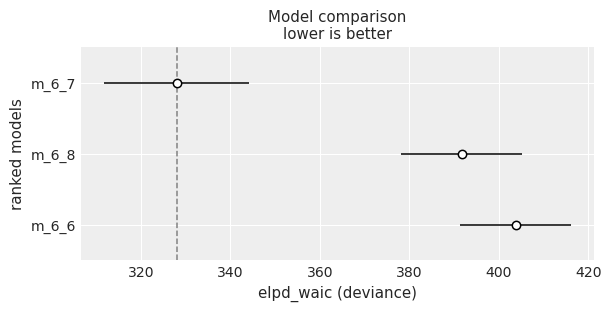

In [ ]:
az.plot_compare(compare_df)

#### Code 7.30

What causal conclusion can we draw from the math and graph? It confirms that WAIC is a specialist meaning that its job is to guess predictive accuracy, not to infer causation. We know the treatment works because we simulated the data, but because fungus is the "pipe" through which the treatment acts, the fungus is more directly correlated with the outcome. Therefore, a model using fungus predicts better and WAIC correctly identifies this. WAIC isn't "wrong" for preferring the confounded model but it's simply telling us that if you want to know how tall a plant will be then knowing if it has fungus is more informative than knowing which treatment it received.

This doesn't make these criteria useless. They provide a precise measure of how much extra information a variable like "fungus" provides. While the treatment is effective, it isn't a 100% guarantee, so knowing the treatment is no substitute for knowing the actual fungus state if your only goal is a good guess. Interestingly, when we compare the treatment-only model (`m_6_8`) to a model with nothing but an intercept (`m_6_6`), WAIC finds them surprisingly similar, with only a 3-unit difference. This serves as a reminder that a "causally correct" variable might only provide a small boost in predictive power, depending on the noise in the system.

In [ ]:
waic_m_6_6 = az.waic(m_6_6_trace, var_name="h1", pointwise=True, scale="deviance")

diff_m6_6_m6_8 = waic_m_6_6.waic_i - waic_m_6_8.waic_i

n = len(diff_m6_6_m6_8)

np.sqrt(n * np.var(diff_m6_6_m6_8)).values

array(9.01479417)

#### Code 7.31

dSE is calculated by compare above, but `rethinking` produces a pairwise comparison. This is not implemented in `arviz`, but we can hack it together:

In [ ]:
dataset_dict = {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace}

# compare all models
s0 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]
# the output compares each model to the 'best' model - i.e. two models are compared to one.
# to complete a pair-wise comparison we need to compare the remaining two models.

# to do this, remove the 'best' model from the input data
del dataset_dict[s0.index[0]]

# re-run compare with the remaining two models
s1 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]

# s0 compares two models to one model, and s1 compares the remaining two models to each other
# now we just nee to wrangle them together!

# convert them both to dataframes, setting the name to the 'best' model in each `compare` output.
# (i.e. the name is the model that others are compared to)
df_0 = s0.to_frame(name=s0.index[0])
df_1 = s1.to_frame(name=s1.index[0])

# merge these dataframes to create a pairwise comparison
pd.merge(df_0, df_1, left_index=True, right_index=True)

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,m_6_7,m_6_8
m_6_8,14.632757,0.000000
m_6_6,16.096586,8.902418


**Note:** this work for three models, but will get increasingly hack-y with additional models. The function below can be applied to *n* models:

In [ ]:
def pairwise_compare(dataset_dict, metric="dse", **kwargs):
    """
    Calculate pairwise comparison of models in dataset_dict and format as a
    triangular matrix matching the ArviZ/Rethinking style.

    Parameters
    ----------
    dataset_dict : dict
        A dict containing two or more {'name': pymc.backends.base.MultiTrace} items.
    metric : str
        The name of the metric to be calculated (default "dse").
    kwargs
        Arguments passed to `arviz.compare`, such as ic="waic" and scale="deviance".
    """
    # 1. Get the baseline comparison to establish the rank order of models
    full_compare = az.compare(dataset_dict, **kwargs)
    ranked_models = full_compare.index.tolist()

    # 2. Create an empty DataFrame with ranked models as both index and columns
    results = pd.DataFrame(index=ranked_models, columns=ranked_models)

    # 3. Perform pairwise comparisons
    # We iterate through each model and compare it against the subset of models ranked below it
    for i, model_name in enumerate(ranked_models):
        if i == len(ranked_models) - 1:
            # The last model has nothing below it to compare to
            results.loc[model_name, model_name] = 0.0
            break

        # Create a temporary subset for comparison containing current model and those below it
        current_subset = {name: dataset_dict[name] for name in ranked_models[i:]}

        # Run comparison on the subset and extract the requested metric
        comp_subset = az.compare(current_subset, **kwargs)

        # Fill the column in our results table
        # .loc[ranked_models[i:]] ensures we only fill rows for models in this subset
        results.loc[ranked_models[i:], model_name] = comp_subset[metric]

    # 4. Final formatting: Fill NaNs with empty strings or keep as NaN to match style
    # The diagonal is usually 0.0 or blank; here we ensure it's numerical for consistency
    return results.astype(float)

In [ ]:
dataset_dict = {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace}
pairwise_compare(dataset_dict, metric="dse", ic="waic", scale="deviance")

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the

,m_6_7,m_6_8,m_6_6
m_6_7,0.000000,NaN,NaN
m_6_8,14.553965,0.000000,NaN
m_6_6,15.956053,9.014794,0.0


The matrix of pairwise differences reveals that for models like `m_6_6` and `m_6_8`, the standard error of the difference is actually larger than the difference itself. This means that, purely on the basis of WAIC, these models are essentially indistinguishable. This however does not imply that the treatment is ineffective. We know it works because we simulated the data and can see a reliably positive treatment effect in the posterior distribution. It simply means the effect isn't large enough to significantly move the needle on predictive accuracy amidst all the other noise in the system.

This result reinforces the central reality that WAIC and its cousins measure predictive impact, not causal truth. A variable can be a genuine cause of an outcome but have such a small relative effect that it barely improves a forecast; WAIC will accurately report this lack of predictive power. Consequently, we cannot use these criteria to determine whether an effect exists. To understand existence and causation, we must instead inspect the posterior distributions of multiple models and analyze the conditional independencies of our causal graphs.

The final column in the comparison table, **weight**, provides a traditional summary of relative support for each model. Within a set, these weights always sum to 1, with the weight for model $i$ calculated as:

$w_i = \frac{\exp(-0.5 \triangle_i)}{\sum_j \exp(-0.5 \triangle_j)}$

where $\triangle_i$ represents the `dWAIC` value (the difference between a model’s WAIC and the best in the set). While weights offer a quick snapshot of relative performance and are often used in **model averaging** to combine predictions (often multiple ones from different models). The reason for this is because they are insufficient on their own because they do not account for standard errors, they must always be interpreted alongside a measure of uncertainty to provide a complete picture of model comparison.

### **7.5.2. Outliers and other illusions.**

In the divorce example from [Chapter 5](https://vanislekahuna.github.io/Statistical-Rethinking-PyMC/Chp_05.html), we saw from the posterior that there were a few states like Idaho which deviated from the model's predictions and influenced the regression. Let's see how PSIS and WAIC would assess those differences.

#### Code 7.32

From our prior modelling with [`m_5_3`](https://vanislekahuna.github.io/Statistical-Rethinking-PyMC/Chp_05.html#approximating-the-posterior), we established that marriage rate ($M$) had little association to the divorce rate ($M$) once the age of marriage was included.

In [ ]:
dataset = "https://raw.githubusercontent.com/vanislekahuna/Statistical-Rethinking-PyMC/refs/heads/main/Data/WaffleDivorce.csv"
d = pd.read_csv(dataset, delimiter=";")

d["A"] = stats.zscore(d["MedianAgeMarriage"])
d["D"] = stats.zscore(d["Divorce"])
d["M"] = stats.zscore(d["Marriage"])

In [ ]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)

    mu = a + bA * d["A"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"].values)

    m_5_1_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bM * d["M"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"].values)

    m_5_2_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"].values + bM * d["M"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"].values)

    m_5_3_trace = pm.sample(return_inferencedata=True)

Output()

Output()

Output()

#### Code 7.33

Now let's compare these models using PSIS and analyze the outcome. In this comparison, two key patterns emerge.

First, the model that omits marriage rate (`m_5_1`) ranks at the top, despite having a slightly worse fit to the training data than the more complex model (`m_5_3`). This occurs because marriage rate has a very weak association with the outcome. Therefore by removing it, we reduce the model's complexity without losing meaningful information which improves its expected performance on new data. The difference between these top two models is tiny, only 1.8 units of deviance with a standard error of 0.9, indicating that their predictions are essentially interchangeable. This is the classic signature of a predictor that adds noise rather than signal.

Second, the appearance of a warning regarding high **Pareto  values** ( $ > 0.5$ or $1$) indicates that the PSIS approximation has become unreliable for certain data points. These high values usually flag **influential outliers** which are observations that are so unlikely according to the model that they exert a massive pull on the parameter estimates. Because a new, independent sample is unlikely to contain these exact same outliers, relying on a model influenced by them can lead to much worse out-of-sample predictions than the criteria suggest. While WAIC lacks the automatic warning system of PSIS, it is equally vulnerable to these influential points. In WAIC, this risk is reflected in a high overfitting penalty ($p_{WAIC}$) for those specific observations.

In [ ]:
pm.compute_log_likelihood(m_5_1_trace, model=m_5_1) # Comment out if there's an error
pm.compute_log_likelihood(m_5_2_trace, model=m_5_2) # Comment out if there's an error
pm.compute_log_likelihood(m_5_3_trace, model=m_5_3) # Comment out if there's an error

az.compare(
    {"m_5_1": m_5_1_trace, "m_5_2": m_5_2_trace, "m_5_3": m_5_3_trace},
    scale="deviance",
    var_name="D",
)

Output()

Output()

Output()

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m_5_1,0,127.034658,3.778278,0.000000,8.934808e-01,12.756452,0.000000,False,deviance
m_5_3,1,128.372471,4.627407,1.337813,5.018664e-18,12.571449,0.886782,False,deviance
m_5_2,2,140.463653,3.049582,13.428995,1.065192e-01,9.936995,9.288573,False,deviance


### Figure 7.10. Highly influential points and test set predictions.

#### Code 7.34

Now let's see which states are causing the problem:

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Text(0.6, 8, "Figure 7.10. Highly influential points and \n     out-of-sample predictions. The horizontal axis \n     is Pareto $k$ from PSIS. The vertical axis is \n     WAIC's penalty term. The State of Idaho (ID) \n     has an extremely unlikely value according to  \n     the model. As a result, it has both a very high  \n     Pareto $k$ and a large WAIC penaly. Points  \n     like these are highly influential and potentially  \n     hurt predictions.")

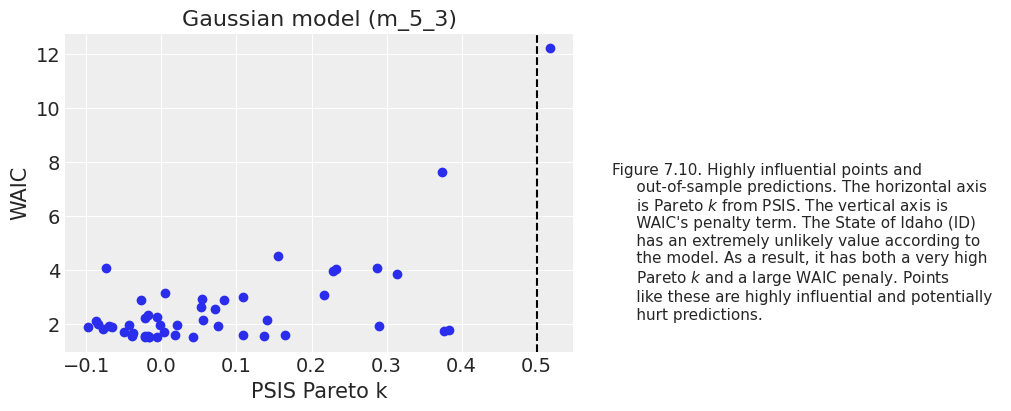

In [ ]:
psis_m_5_3 = az.loo(m_5_3_trace, var_name="D", pointwise=True, scale="deviance")
waic_m_5_3 = az.waic(m_5_3_trace, var_name="D", pointwise=True, scale="deviance")

# Figure 7.10
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(psis_m_5_3.pareto_k, waic_m_5_3.waic_i)
ax.set_xlabel("PSIS Pareto k")
ax.set_ylabel("WAIC")
ax.set_title("Gaussian model (m_5_3)")
ax.axvline(0.5, color="black", linestyle="--")

caption_text = (
    "Figure 7.10. Highly influential points and \n \
    out-of-sample predictions. The horizontal axis \n \
    is Pareto $k$ from PSIS. The vertical axis is \n \
    WAIC's penalty term. The State of Idaho (ID) \n \
    has an extremely unlikely value according to  \n \
    the model. As a result, it has both a very high  \n \
    Pareto $k$ and a large WAIC penaly. Points  \n \
    like these are highly influential and potentially  \n \
    hurt predictions."
)

ax.text(0.6, 8, caption_text, fontsize=11,
        verticalalignment='top', horizontalalignment='left')

By inspecting the data pointwise, we can identify exactly which observations are breaking our predictive approximations. When we plot the Pareto $k$ values from PSIS against the overfitting penalties from WAIC, we see a clear relationship: Points that are difficult for the model to "digest" score high on both axes. In this analysis, Idaho (ID) stands out in the upper-right corner as a severe outlier. As we saw in Chapter 5, Idaho has a divorce rate that is unusually low for its age at marriage, making it highly influential. Its Pareto $k$ value is over 1.0, which is double the threshold where the variance of the importance weights becomes infinite,and its WAIC penalty is over 2.0. While the total penalty for a model usually approximates the number of parameters (which is 4 here), Idaho’s influence pushes that total closer to 6, signaling a massive localized risk of overfitting.

When faced with such outliers, there is a common but dangerous tradition of dropping them before even fitting a model. You should never do this. An observation is only an "outlier" in the context of a specific model's expectations. If you must drop a point, you should only do so after modeling and must report the results both with and without that point. However, if multiple outliers exist, the problem often isn't the data, but the model's architecture.

The fundamental issue here is that the Gaussian distribution is "easily surprised." Because it has very thin tails, it assigns almost zero probability to observations far from the mean. While some phenomena, like human height, fit this thin-tailed profile perfectly, many others naturally produce extreme observations. These aren't necessarily measurement errors, they are real events that suggest our model needs a more robust distribution—one with thicker tails that won't be so easily shocked by a single Idaho.

### Figure 7.11. Thin tails and influential observations.

To handle extreme observations without discarding them, we can use robust regression. This typically involves replacing the Gaussian error model with a distribution that has "thicker tails," such as the Student-$t$ distribution. While the Gaussian distribution (shown in blue in **Figure 7.11**) is thin-tailed and easily "surprised" by outliers, the Student-$t$ distribution (shown in black) allocates more probability mass to values far from the mean. This difference is most striking on the log scale where the Gaussian tails plummet quadratically like an inverted parabola while the Student-$t$ tails decay much more slowly.

The Student-$t$ distribution is defined by the same mean ($\mu$) and scale ($\sigma$) as the Gaussian, but adds a third parameter: $\nu$. This shape parameter controls the thickness of the tails. At very high values of $\nu$, the distribution is identical to a Gaussian. As $\nu$ approaches 1, the tails become much thicker, allowing for rare, extreme events to occur more frequently without shocking the model.

If we have a large dataset of events, such as stock market data, we could estimate $\nu$. In practice, we rarely have enough data to estimate $\nu$ precisely, so we often fix it at a small value to ensure the regression is robust and to reduce the influence of other outliers. Because the Student-$t$ distribution expects extreme values to happen occasionally, a single point like Idaho won't exert such a massive influence on the other parameters. This approach allows us to learn from the information contained in the bulk of the data while acknowledging that extreme observations are a real, albeit rare, part of the process.

Text(0, -0.1, 'Figure 7.11. Thin tails and influential observations. The Gaussian distribution \n     (blue) assigns very little probability to extreme observations. It has thin tails. \n     The Student-t distribution with shape $v$ = 2 (black) assigns more probability \n     to extreme events. These distributions are compared on the probability (left) \n     and log-probability (right) scales.')

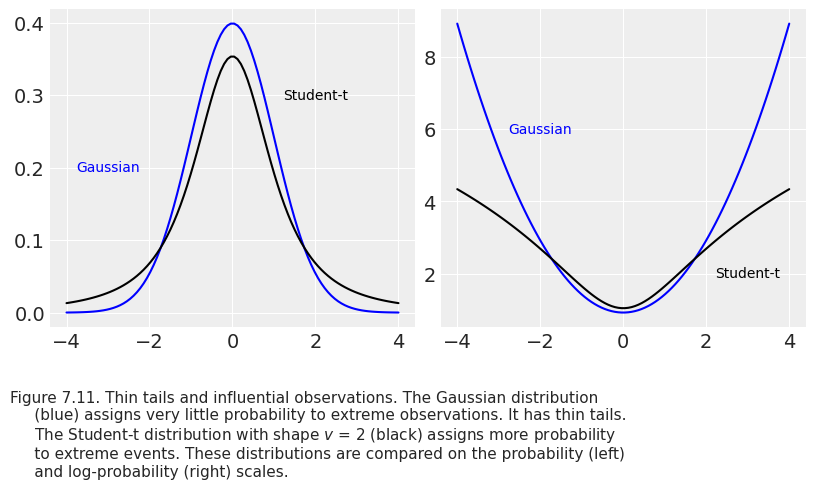

In [ ]:
v = np.linspace(-4, 4, 100)

g = stats.norm(loc=0, scale=1)
t = stats.t(df=2, loc=0, scale=1)

fig, (ax, lax) = plt.subplots(1, 2, figsize=[8, 3.5])

ax.plot(v, g.pdf(v), color="b")
ax.text(2, 0.3, 'Student-t', color='k', fontsize=10, ha='center', va='center')

ax.plot(v, t.pdf(v), color="k")
ax.text(-3, 0.2, 'Gaussian', color='b', fontsize=10, ha='center', va='center')

lax.plot(v, -g.logpdf(v), color="b")
lax.text(3, 2, 'Student-t', color='k', fontsize=10, ha='center', va='center')

lax.plot(v, -t.logpdf(v), color="k")
lax.text(-2, 6, 'Gaussian', color='b', fontsize=10, ha='center', va='center')

caption_text = (
    "Figure 7.11. Thin tails and influential observations. The Gaussian distribution \n \
    (blue) assigns very little probability to extreme observations. It has thin tails. \n \
    The Student-t distribution with shape $v$ = 2 (black) assigns more probability \n \
    to extreme events. These distributions are compared on the probability (left) \n \
    and log-probability (right) scales."
)

fig.text(0, -0.1, caption_text, fontsize=11,
        verticalalignment='top', horizontalalignment='left')

#### Code 7.35

Let's now re-estimate the divorce model using a Student-t distribution with a $\nu = 2$:

In [ ]:
with pm.Model() as m_5_3t:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"].values + bM * d["M"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.StudentT("D", nu=2, mu=mu, sigma=sigma, observed=d["D"].values)

    m_5_3t_trace = pm.sample(return_inferencedata=True)

Output()

Implementing the Student-$t$ distribution in the divorce model (m5.3t) immediately yields tangible results: Now the PSIS warnings about high Pareto $k$ values disappear. By switching to a thick-tailed distribution, the model is no longer "surprised" by Idaho, and the state's relative influence on the parameter estimates is significantly reduced.

This shift in influence directly impacts our conclusions. In the original Gaussian model, Idaho—with its unusually low divorce rate and low age at marriage—exerted enough pull to weaken the apparent relationship between those two variables. Once we use robust regression to "skepticize" the model against such outliers, the association between age at marriage and divorce ($bA$) actually moves further from zero, thus revealing a stronger relationship that was previously being masked. This demonstrates the power of robust regression where by preventing a few extreme data points from distorting the results, we can often uncover a more accurate representation of the patterns shared by the rest of the data. However as with any statistical adjustment, the specific impact on your coefficients will always depend on the unique geometry of the outliers in your dataset.

In [ ]:
pm.compute_log_likelihood(m_5_3t_trace, model=m_5_3t) # Comment out if there's an error
az.loo(m_5_3t_trace, var_name="D", pointwise=True, scale="deviance")

Output()

,0
elpd_loo,134.24741
se,11.515007
p_loo,6.43868
n_samples,2000
n_data_points,50
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,deviance
good_k,0.697064


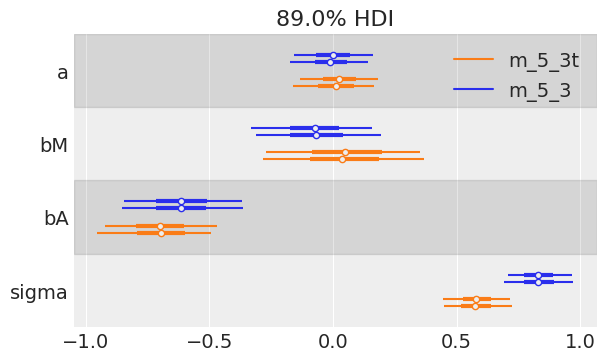

In [ ]:
az.plot_forest([m_5_3_trace, m_5_3t_trace], model_names=["m_5_3", "m_5_3t"], figsize=[6, 3.5]);

## ***Section 7.6* - Summary**

- In previous chapters, we learned that adding **variables / weights / predictors / features** can both help (by revealing hidden effects) and hurt (by causing collider bias when the causal model is flawed). Since there are many predictive models to select from, one of the first decisions we must make is to *determine whether the goal of our model is to <u>make predictions</u> or <u>understand causal relationships</u>*.
- If our goal is to optimize predictive accuracy, will simply adding more variables improve the model's predictive accurracy? The answer is yes, it will increase the accuracy. However it will also cause further issues that we can't ignore, especially if we fit a complex **polynomial regression** (such as the one in the example below or the visual in [Figure 7.3.](#scrollTo=_9m79q6PCp0A)) which is generally not encouraged without theoretical justification:

  $ b_i \sim \text{Normal}(\mu_i, \sigma) $

  $ \mu_i = \alpha + \beta_1 m + \beta_2 m^2 + \beta_3 m^3$

  $ \alpha \sim \text{Normal}(0.5, 1) $

  $ \beta_j \sim \text{Normal}(0, 10) \text{ for } j = 1..3  $

  $ \sigma \sim \text{Log-Normal}(0, 1) $

  Note: *In the line for  parameter $B_j$  where it says  for $j=1..3$, this is a concise way for saying "for  j  equals 1 to 3.". Another way to say this is that the prior of  $β_j \sim \text{Normal} ( 0 , 10 ) $  applies separately to both $\beta_1$,  $\beta_2$, and $\beta_3$*.

  - One of these issues is that additional parameters actually increases the model's **complexity** and increases the amount of **variance** which decreases our $R^2$ score since it's designed to measure the variance that a model can account for: $ R^2 = \frac{SS_\text{Resid} = \sum_{i=1}^{n} (y - \hat{y})^2}{SS_\text{Total} = \sum_{i=1}^{n} (y - \bar{y})^2}$
  - The second issue is that complex models tend to **overfit**. In the case of a polynomial regression for example, if your model is complex enough where parameters = data points, you can achieve a perfect fit but it will also make ridiculous predictions for any new data.
- **Overfitting** is when the model learns too much about the quirks/noise of the data and not enough about the relavent features its target variable. Every sample dataset contains **regular features** that scale to the larger population as we collect more data. In the case of overfitting, not only does the model learn the regular features but also the **irregular features** which represent the noise.
  -  One solution for dealing with the problems of overfitting its training data is to "dumb down" our model's preformance through **regularization** (also known as a **regulated prior** in Bayesian circles). There's two approaches we can take:
      1. Use the **L1 Penalty** (also known as **Lasso Ridge**) which is similar to **feature selection** where it reduces the weight of certain predictors;
      2. Or go with the **L2 Penalty** (also known as **Ridge Regression**) which lowers the impact of ALL the model's weights uniformly across the board.
  - Another solution we'll cover is to use **cross validation** or **information criteria** like AIC, DIC, WAIC, or PSIS-LOO to evaluate a model's preformance.
- **Underfitting** is when the model learns too little and can't pick up on a meaningful relationship between the features and the target.
> *Generally, one way to interpret models is to consider them as a form of data compression or note taking where you want to learn the main ideas without rehashing an entire textbook or lecture. With data, **true learning** is the balance of compressing the data enough where the model captures the regular features.*
- **Confounding** is when the model infers relationships about variables in the model that don't actually exist.

- In order to evaluate a model's predictive accuracy, we want to be mindful about optimizing for the metric that is *maximized by the **[true data-generating model](#scrollTo=Ws0BZCux6x8c)***.
- To better understand this idea, we can turn to the field of **information theory** which defines **information** simply as the reduction of uncertainty when we learn of an outcome.
- **Infomation Entropy ($H(p)$)** is the "inherent uncertainty" of a target variable's (or anything for that matter) *true* probability distribution. Another way to think about it is that amount of "surprise" we get based on a set of outcomes we observe. For something to considered "uncertain," it must satisfy the <u>3 axioms</u> of information entropy:
  1. **Continuity**: Small changes in probability should only cause small changes in uncertainty.
  2. **Monotonicity**: Increased Event Outcomes = Increased Uncertainty
  3. **Additivity**: The total uncertainty of a system should be the same regardless of how they're grouped together. For example if forced to choose between four outcomes ($A, B, C,$ or $D$), the total uncertainty should remain the same despite the order in which you make those choices.
  - If you examine the mathematical equation for **information entropy**, $H(p)$, you'll realize that it's simply the *average log-probability of an event* or our *[average uncertainty over a set of possible outcomes](#scrollTo=yEVEEkMWBhlr)* (usually measured in bits). In the real world, scientists never actually *know* the probability over those set of outcomes we're inputting in the information entropy formula and instead try to come up with various tactics to create a "proxy truth." In our examples, we're always playing God in these simulations by hardcoding a 50/50 or 70/30 split over two possible outcomes such as land vs water or fire vs no fire. Then with our information critieria, such as WAIC or PSIS, we're attempting to see how close these techniques can come to our hardcoded true probabilities. One small thing to add is that we must multiply this value by $-1$ to ensure that the resulting value increases from zero rather than decreases. A higher number indicates greater unpredictability: $H(p) =  -\sum_{i=1}^{n} p_i \log(p_i)$
    - As an aside, an important application of information theory is the concept of **maximum entropy** (or **MaxEnt**) which aims to find the probability distribution that leads to lowest possible value of information entropy. Bayesian updating is inherently as process of MaxEnt as it seeks to minimize the information entropy using the least amount of additional information.
- If we're able to quantify the uncertainty in our target variable using information entropy, the next step is to measure how far our model's predictions ($q$) **diverges** from the target variable's "true probability" ($H(p)$). In other words, **Kullback-Lebler (K-L) Divergence** is the cost of being wrong. Another way we can think of **KL Divergence ($D_{KL}$)** is that it's the additional uncertainty that's introduced from the output of our model approximation instead of the actual truth.
  - For example, suppose the "True" probability of a fire is 50% ($p$), but the insurance company uses an outdated model ($q$) that estimates the risk at only 10%. Because the model is wrong, the insurer will be constantly caught off guard by the frequency of fires. **KL Divergence** measures exactly how far off their model is from the actual reality.
- Mathematically, we can define **KL Divergence** as the average distance in log probability between our target variable's "true distribution" ($p$) and the model's predicted distribution ($q$):

  $ D_{KL}(p, q) = \sum_{i=1}^{n} p_i \text{log}(\frac{p_i}{q_i}) $

  $ D_{KL}(p, q) = \sum_{i=1}^{n} p_i ( \text{log}(p_i) - \text{log}(q_i)) $

  - So if our KL divergence equates to zero (i.e. $p = q$), it means our model's predicted reality with perfect accuracy. If we use KL Divergence alone to compare between different model then we'll want to select the one that minimizes this **divergence**.
- Now that we know the inherent uncertainty of a target variable from information entropy ($H(p)$) as well as the additional uncertainty introduced from our model being wrong, as measured by KL Divergence ($ D_{KL}(p, q) $), we can finally calculate Cross Entropy using these two foundational concepts. **Cross Entropy** is the *sum* of the information entropy and KL Divergence as it represents the total uncertainty brought about from the target's inherent uncertainty as well as the *prediction error* (also known as *residual*) from our model's approximation:

  $H(p, q) = H(p) + D_{KL}(p, q ) $

  $H(p, q) =  -\sum_{i=1}^{n} p_i \log(q_i)$

- When working with real world data, since we don't know the true probabilities for the target ($p_i$), we treat our data as $p_i$ since in reality it represents a slice of it, calculate the log probability of our model's output, and take the average of these log probabilities to generate an **estimate of cross entropy**. Intuitively, **cross entropy** is the relative difference between the two models and how much closer they are to the target, even without knowing where the target is located and the smaller this number is, the closer the model is to the true distribution of the target variable.
  - Let's use an example where we found that there was a 70% chance of fire in a region of interest based on our dataset because there had been 70 fires in the past 100 years. We then built two models that had differing opinions on the probability of fire this year. Model 1 ($q_1$) estimates a 40% chance while Model 2 ($q_2$) estimates a 60% chance. Right away, we know that Model 2 is closer to the true probability but first let's see if Cross Entropy verifies this.

    Let's first calculate the **Information Entropy** of the wildfires in this region (i.e. the inherent uncertainty):

    $H(p) = -[0.7 \log(0.7) + 0.3 \log(0.3)] \approx \mathbf{0.611}$

    Next let's calculate the **Cross Entropy** for Model 1 ($q_1$):

    $H(p, q) =  -\sum_{i=1}^{n} p_i \log(q_i)$

    $H(p, q_1) = -[0.7 \log(0.4) + 0.3 \log(0.6)] \approx \mathbf{0.795}$

    Then Model 2 ($q_2$):

    $H(p, q) =  -\sum_{i=1}^{n} p_i \log(q_i)$

    $H(p, q_2) = -[0.7 \log(0.6) + 0.3 \log(0.4)] \approx \mathbf{0.632}$

    Now that we know the cross entropy of the two models, even though in real life we're not supposed to know the actual probabilities of fire for a given area, we can use the difference between the two values ($ 0.795 - 0.632 = 0.163$) to say with *mathematical certainty* that:

  >  "Model 2 is **0.163 units (bits) closer** to the true physical reality than Model 1."

- Now if we went one step further and calculated the cross entropy of an entire posterior distribution, our "model" ($q$) would represent that entire distribution rather than the one number. Using **Log-Pointwise-Predictive-Density (LPPD)**, we'll calculate the average probability of the data across all our samples ($s$) in the posterior.

  - For example, let's say our posterior consisted of just three predictions: $0.4, 0.6, 0.8 $. The intuition here is that LPPD is merely taking the *log* of the *average* of these probabilities.

    $\text{Average Probability} = \frac{0.4 + 0.6 + 0.8}{3} = 0.6$

    $\text{LPPD for this day} = \log(0.6) \approx -0.51$

    $\text{LPPD} = \text{log} \left( \frac{1}{S} \sum_{s=1}^S p(y_i | \theta_s ) \right) $

- From a Bayesian sense, **regularization** or a **regularizing prior** is essentially a "skeptical" or [tight prior](#scrollTo=70hpIzTRNmmC) centred around zero or the sample mean in order to address overfitting and reduce a model's rate of learning. However, there's a balance to using regularization because if the prior is too skeptical, it can't learn the important patterns and will result in underfitting.
  - With tighter priors, you may find that (especially with smaller samples) a **regularized prior** may result in higher variance during the training set but then we'll find a lower variance score (higher predictive accuracy) once we test the model on the test set. This is especially the case with more complex models that have a higher parameter count.
  - However as we increase the sample like we did in [Figure 7.8](#scrollTo=2M3FLVxVNy5Q), the skepticism of these tighter priors wear off from exposing the model to more data which illustrates the utility of **regularized priors** in the face of limited data!
- In machine learning, it's common to use a technique known as **cross validation** to evaluate the preformance of a model by setting aside a "**test set**" of the training data for it to test its predictions against the real-world observations. If our datasets are large enough, this is also done with a "**validation set**" within the training set first to iterate on our model's preformance before exposing it to the test set in order to prevent **leakage**.
- We can take this idea one step further with the gold standard **leave-one-out-cross-validation (LOOCV)** technique where you create a test set with just a single sample from the dataset to evaluate if the model is able to make a prediction that's identical to our single "test set." We'll then repeat this process until every value in our target variable has been used as a test set then we average the log of these probabilities to get an output called the **Expected Log Predictive Density (ELPD)**. While ideal, this method is extremely computationally expensive as a dataset with 1,000 observations will net you 1,000 separate posterior distributions. Nonetheless, here's an equation to describe this process so we can learn the intuition before discussing a computational workaround:

  $\text{ELPD}_{loocv} = \sum_{i=1}^{n} \log p(y_i | y_{-i})$
  
  *Where*:
  - $y_i$: The observation we "left out" (the test fire).
  - $y_{-i}$: All the observations except $i$ (the training fires).
  - $p(y_i | y_{-i})$: The probability the model assigns to the missing fire $i$ after being trained on all other fires.
  - $\sum_{i=1}^n$: We sum the logs of these probabilities (or average them) to get the total score.

- The way to overcome computational limitation by using the [**Pareto-smoothed importance sampling (PSIS)**](#scrollTo=tH0W48xdSpbJ) technique which instead estimates the "importance" of each observation based on how unlikely an observation(s) is and flagging the ones that are most likely to have an impact in the model's posterior distribution.
- Another way we can evaluate how well a model will generalize to unseen data is through **information criteria** and the main one we'll utilize is WAIC. The **Widely Applicable Information Criterion (WAIC)** balances a model's complexity with its preformance on the training data (using LPPD) to evaluate their ability to generalize on unseen data. The simplified intuition for **WAIC** is the following equation where "fit" is evaluated using `lppd` and "complexity" is represented by a penalty term:

  `WAIC = -2 * (Fit - Complexity)`
  - The penalty term in the full equation below measures a model's complexity by computing the variance in prediction log probabilities for each test set observation ($i$) and then summing up these variances to get the to total penalty: $ \text{WAIC}( y, \Theta ) = 2 ( \space \text{lppd} - \underbrace{\sum_{i} \text{var}_{\theta} \log p ( y_i | \Theta ) \space )}_{\text{penalty term}} $

  - Because WAIC is "pointwise" meaning that it evaluates predictions on a point-by-point basis, we can actually use central limit theorem to calculate a **standard error for our WAIC estimate for each observation**: $ s_{WAIC} = \sqrt{N \text{var} - 2 ( \text{lppd}_i - p_i ) } $

  - While WAIC and cross-validation can produce similar results with large samples, they are theoretically distinct and gives us two tools to evaluate how our models will generalize to unseen data. And with smaller datasets, these two evaluation methods will disagree because WAIC is fundamentally trying to guess the out-of-sample KL Divergence.

- The general "train-test" approach in machine learning comes with a "uniformitarian" assumption that future data will resemble past data. If, for example, we were to fit a model predicting height from weight on population data gathered from a 3rd world country, these statistical tools won't help us if it's tasked to make predictions about living in a 1st world country where there's an abundance of growth factors such as clean air and healthy food. Good modeling requires not just statistics, but also a deep, scientific understanding of the process we're trying to study in order to adapt to changing environments.

- Although we now have several tools to evaluate models, it's important not to discard other models that aren't as preformative because we lose information about the differences of their scores. Instead, we can utilize **model comparison** by identifying how different variables influence the model's predictions and, with causal reasoning, to identify meaningful relationships. The goal is not just to find the top performer, but to understand overfitting, fine-tune models, and pinpoint where and why predictions fail to distinguish between models that predict well and those that explain well.
- Another common practice in machine learning is to drop outliers before fitting to a model but as much as possible, refrain from doing this because a data point is only considered an "outlier" in the context of a model's (or modeller) expectation. The exception to this is if you have strong evidence the outlier is an error after modelling (e.g., a data entry mistake).
  - An alternative to a Normal/Gaussian distribution which isn't as easily "surprised" by outliers is the **Student-$t$ distribution** which allocates more probability mass to outliers.
  - **Student-$t$ distribution** is similar to it's Gaussian cousin where the mean/location ($\mu$) and scale/standard deviation ($\sigma$) parameters define it's probability distribution but with the addition of the **degrees of freedom ($\nu$)** shape parameter that defines the thickness of the tail. As $\nu$ approaches 1, the tails become much thicker, allowing for outlier events to occur more frequently without shocking the model. But the larger this parameter becomes, the more is starts to resemble a Gaussian distribution.
  - For example if we add a Student-$t$ to our divorce model in [Code 7.35](#scrollTo=XUMMiSYFCp06), we'll immediately notice an improvement in the model's preformance because it isn't as easily "surprised" by our outlier data point - Idaho.


In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

ModuleNotFoundError: No module named 'watermark'